# *IT5006 Project MileStone 2*

## Project Overview
This notebook implements a comprehensive machine learning pipeline for predicting hospital readmissions within 30 days using the UCI Diabetes 130-US hospitals dataset. The analysis compares multiple algorithms with and without SMOTE (Synthetic Minority Oversampling Technique) to handle class imbalance.

### Key Objectives:
- **Binary Classification**: Predict whether a patient will be readmitted within 30 days (1) or not (0)
- **Class Imbalance Handling**: Evaluate baseline models and compare them with SMOTE variants for fair assessment.
- **Model Comparison**: Test multiple algorithms across different feature groups.
- **Final Selection**: Identify the model with optimized parameters for the best readmission prediction performance which suites our business goal

### Methodology:
1. **Data Preprocessing**: Handle missing values, encode categorical features, scale numerical features
2. **Feature Engineering**: Create clinical metrics, medication summaries, and risk indicators
3. **Base Model Selection**: Choose commonly used models for binary classification.
4. **Class Balancing**: Apply SMOTE variants to address the inherent class imbalance in readmission data
5. **Models Fairness**: Standardize hyperparameters across models of the same type to ensure fair comparison.
6. **Pipeline Construction**: Build end-to-end pipelines covering preprocessing, feature engineering, and model training.
7. **Evaluation**: Compare models using ROC Curve, ROC AUC, Precision,F1-score
8. **Threshold Training**: Determine optimal classification thresholds for selected models.
9. **Hyperparameter Tuning**: Further optimize the final model selection by adjusting hyperparameters.


# **Data and Package Loading**

## Package Installation and Environment Setup

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
!pip3 install -U ucimlrepo
!pip install category_encoders
!pip install lightgbm
!pip install xgboost

## Library Import Configuration


In [3]:
from ucimlrepo import fetch_ucirepo, list_available_datasets
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 80)
import pprint
from sklearn.model_selection import train_test_split,GridSearchCV,StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler, OneHotEncoder,FunctionTransformer,OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import roc_auc_score,accuracy_score, classification_report, confusion_matrix,roc_curve,precision_recall_fscore_support, precision_score,recall_score,silhouette_score, davies_bouldin_score,average_precision_score,precision_recall_curve
from sklearn.feature_extraction import FeatureHasher
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.combine import SMOTETomek, SMOTEENN
import lightgbm as lgb
import category_encoders as ce
from sklearn.naive_bayes import GaussianNB, MultinomialNB, CategoricalNB
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from statsmodels.stats.outliers_influence import variance_inflation_factor
import re
# from imblearn.under_sampling import RandomUnderSampler, EditedNearestNeighbours


## Dataset Display


In [4]:
# Check available diabetes datasets
list_available_datasets(search = 'diabetes')

#Load the dataset
ds = fetch_ucirepo(id = 296)
df = ds.data.original.copy()
df_backup = df.copy()
df.head()

-----------------------------------------------------------------
The following datasets are available for search query "diabetes":
-----------------------------------------------------------------
Dataset Name                                     ID    
------------                                     --    
Diabetes 130-US Hospitals for Years 1999-2008    296   
Early Stage Diabetes Risk Prediction             529   
CDC Diabetes Health Indicators                   891   



encounter_id  patient_nbr             race  gender      age weight  \
0       2278392      8222157        Caucasian  Female   [0-10)    NaN   
1        149190     55629189        Caucasian  Female  [10-20)    NaN   
2         64410     86047875  AfricanAmerican  Female  [20-30)    NaN   
3        500364     82442376        Caucasian    Male  [30-40)    NaN   
4         16680     42519267        Caucasian    Male  [40-50)    NaN   

   admission_type_id  discharge_disposition_id  admission_source_id  \
0                  6                        25                    1   
1                  1                         1                    7   
2                  1                         1                    7   
3                  1                         1                    7   
4                  1                         1                    7   

   time_in_hospital payer_code         medical_specialty  num_lab_procedures  \
0                 1        NaN  Pediatrics-Endocrinology                  41   
1                 3        NaN                       NaN                  59   
2                 2        NaN                       NaN                  11   
3                 2        NaN                       NaN                  44   
4                 1        NaN                       NaN                  51   

   num_procedures  num_medications  number_outpatient  number_emergency  \
0               0                1                  0                 0   
1               0               18                  0                 0   
2               5               13                  2                 0   
3               1               16                  0                 0   
4               0                8                  0                 0   

   number_inpatient  diag_1  diag_2 diag_3  number_diagnoses max_glu_serum  \
0                 0  250.83     NaN    NaN                 1           NaN   
1                 0     276  250.01    255                 9           NaN   
2                 1     648     250    V27                 6           NaN   
3                 0       8  250.43    403                 7           NaN   
4                 0     197     157    250                 5           NaN   

  A1Cresult metformin repaglinide nateglinide chlorpropamide glimepiride  \
0       NaN        No          No          No             No          No   
1       NaN        No          No          No             No          No   
2       NaN        No          No          No             No          No   
3       NaN        No          No          No             No          No   
4       NaN        No          No          No             No          No   

  acetohexamide glipizide glyburide tolbutamide pioglitazone rosiglitazone  \
0            No        No        No          No           No            No   
1            No        No        No          No           No            No   
2            No    Steady        No          No           No            No   
3            No        No        No          No           No            No   
4            No    Steady        No          No           No            No   

  acarbose miglitol troglitazone tolazamide examide citoglipton insulin  \
0       No       No           No         No      No          No      No   
1       No       No           No         No      No          No      Up   
2       No       No           No         No      No          No      No   
3       No       No           No         No      No          No      Up   
4       No       No           No         No      No          No  Steady   

  glyburide-metformin glipizide-metformin glimepiride-pioglitazone  \
0                  No                  No                       No   
1                  No                  No                       No   
2                  No                  No                       No   
3                  No                  No                       No   
4        

# **Checks Before Data Split**

## Pre-Processing Data Quality Assessment

**Purpose**: 
- Conduct comprehensive data quality checks before train-test splitting to understand data characteristics and potential issues.
- Address data quality issues before splitting to prevent data leakage and ensure valid model evaluation.

**Steps Taken in the Section**:

1. **Multicollinearity Analysis**
- **Correlation Matrix**: Visual heatmap of numerical feature correlations
- **Variance Inflation Factor (VIF)**: Quantitative measure of multicollinearity

2. **Data Integrity Validation**
- **Duplicate Detection**: Check for duplicate patient encounters

**Statistical Rationale**:
- **Correlation Analysis**: Prevents redundant features that don't add predictive value
- **VIF Calculation**: Uses statistical measure to quantify multicollinearity impact
- **Quality Control**: Establishes data reliability before model training



### Multicollinearity Analysis
#### Correlation Matrix

 Analysis: Threstold > 0.7 indicates strong correlation, no strong correlation found

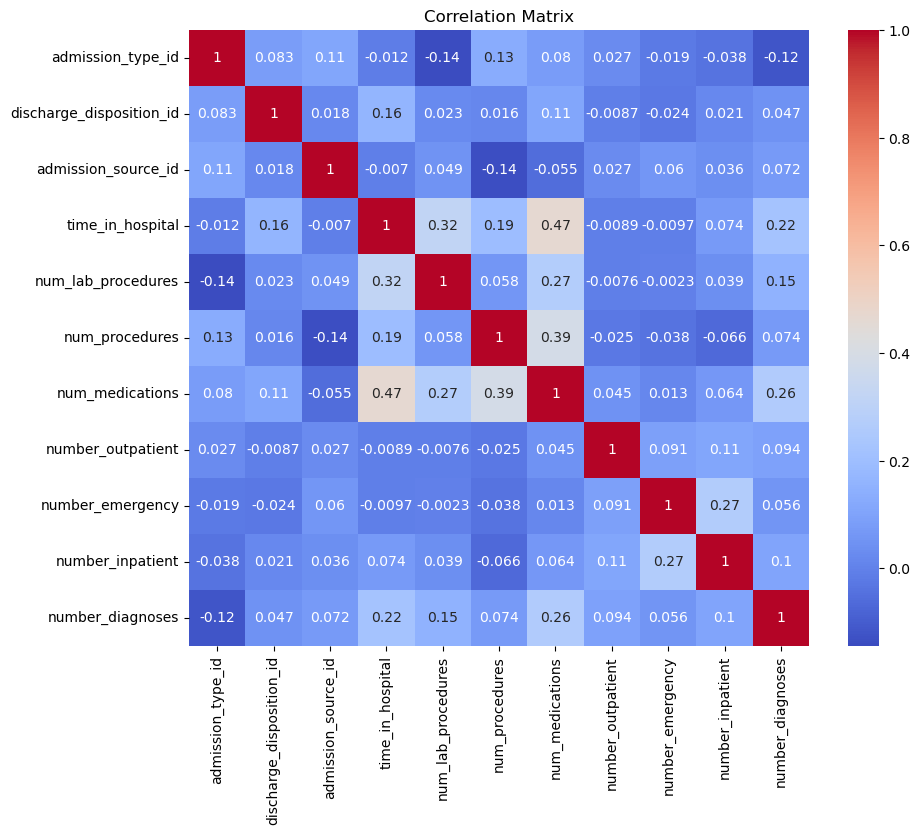

In [5]:
#Before preprocessing, check correlation matrix of numerical features

#Extract numerical values
numeric_cols = [i for i in df.select_dtypes(include=np.number).columns.tolist() if i not in ['encounter_id','patient_nbr']]

#Remove the target (Readmitted)
# x = df.drop('readmitted', axis = 1)

df_numeric = df[numeric_cols]

# Calculate the correlation matrix
corr_matrix = df_numeric.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

### Variance Inflation Factor (VIF)

Analysis: VIF > 10 indicates problematic multicollinearity, no features with strong multocollonearity found

In [6]:
#Compute VIF data for each independent variable
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif['Features'] = df_numeric.columns
vif['VIF'] = [variance_inflation_factor(df_numeric.values, i) for i in range(df_numeric.shape[1])]
vif

Features       VIF
0          admission_type_id  2.799735
1   discharge_disposition_id  1.549168
2        admission_source_id  3.072283
3           time_in_hospital  4.404836
4         num_lab_procedures  6.061649
5             num_procedures  1.982435
6            num_medications  7.567782
7          number_outpatient  1.115344
8           number_emergency  1.136144
9           number_inpatient  1.385807
10          number_diagnoses  9.194745

### Data Integrity Validation
#### Duplicate Detection


Analysis: no duplicate patient encounters

In [7]:
print(df.duplicated(subset=['patient_nbr', 'encounter_id']).any())

False


# **Data Split**

## Strategic Data Splitting and Feature Grouping

**Purpose**: Implement systematic data splitting strategy for comprehensive model evaluation across different feature categories.

**Feature Grouping**:
1. **Demographics**: `race`, `gender`, `age`, `weight` - Basic patient characteristics
2. **Admission Context**: `admission_type_id`, `discharge_disposition_id`, `admission_source_id`, `time_in_hospital` - Hospital encounter details
3. **Healthcare System**: `payer_code`, `medical_specialty` - Insurance and care provider information
4. **Clinical Metrics**: Laboratory, procedure, and medication counts - Quantitative clinical indicators
5. **Diagnosis Codes**: `diag_1`, `diag_2`, `diag_3` - Primary and secondary diagnoses
6. **Laboratory Results**: `A1Cresult`, `max_glu_serum` - Diabetes-specific lab values
7. **Medications**: 23 diabetes medications - Treatment regimen details
8. **Treatment Changes**: `change`, `diabetesMed` - Medication modification indicators

**Train and Test Data Splitting**:
- **Stratified Split**: Maintains target class distribution (80% train, 20% test)
- **Random State**: Fixed seed (42) for reproducible results
- **Group-wise Analysis**: Enables feature importance analysis by category
- **Binary Classification**: Convert 3-class problem (`<30`, `>30`, `NO`) to binary (readmitted within 30 days vs. not)

**Rationale**:
- **Feature Importance**: Identify which feature categories are most predictive
- **Model Comparison**: Evaluate algorithm performance across feature types
- **Clinical Insights**: Understand which aspects of patient data drive readmission risk

In [8]:
data_groups= { "demographics":["race","gender","age","weight"],
              "admission_type":["admission_type_id","discharge_disposition_id","admission_source_id","time_in_hospital"],
              "healthcare_provider":["payer_code","medical_specialty"],
              "clinical_metrics":["num_lab_procedures","num_procedures","num_medications","number_outpatient","number_emergency","number_inpatient","number_diagnoses"],
              "diagnosis":["diag_1","diag_2","diag_3"],
              "laboratory_results":["A1Cresult","max_glu_serum"],
              "medications":["metformin","repaglinide","nateglinide","chlorpropamide","glimepiride","examide","acetohexamide","glipizide","glyburide","tolbutamide","pioglitazone","rosiglitazone","acarbose","miglitol","troglitazone","tolazamide","insulin","citoglipton","glyburide-metformin","glipizide-metformin","glimepiride-pioglitazone","metformin-rosiglitazone","metformin-pioglitazone"],
              "treatment_change":["change","diabetesMed"],
              "identifiers":["patient_nbr","encounter_id"]
              }

x_full = df.drop(columns="readmitted")
y_binary = (df['readmitted'] == '<30').astype(int)
x_demographics = x_full[data_groups["demographics"]]
x_admission_type = x_full[data_groups["admission_type"]]
x_healthcare_provider = x_full[data_groups["healthcare_provider"]]
x_clinical_metrics = x_full[data_groups["clinical_metrics"]]
x_diagnosis = x_full[data_groups["diagnosis"]]
x_laboratory_results = x_full[data_groups["laboratory_results"]]
x_medications = x_full[data_groups["medications"]]
x_treatment_change = x_full[data_groups["treatment_change"]]

data_split_by_group=dict()
### train test split for each group, 0.2 for test size 
x_full_train, x_full_test, y_full_train, y_full_test = train_test_split(x_full, y_binary, test_size=0.2, random_state=42,stratify=y_binary)
x_demographics_train, x_demographics_test, y_demographics_train, y_demographics_test = train_test_split(x_demographics, y_binary, test_size=0.2, random_state=42,stratify=y_binary)
x_admission_type_train, x_admission_type_test, y_admission_type_train, y_admission_type_test = train_test_split(x_admission_type, y_binary, test_size=0.2, random_state=42,stratify=y_binary)
x_healthcare_provider_train, x_healthcare_provider_test, y_healthcare_provider_train, y_healthcare_provider_test = train_test_split(x_healthcare_provider, y_binary, test_size=0.2, random_state=42,stratify=y_binary)
x_clinical_metrics_train, x_clinical_metrics_test, y_clinical_metrics_train, y_clinical_metrics_test = train_test_split(x_clinical_metrics, y_binary, test_size=0.2, random_state=42,stratify=y_binary)
x_diagnosis_train, x_diagnosis_test, y_diagnosis_train, y_diagnosis_test = train_test_split(x_diagnosis, y_binary, test_size=0.2, random_state=42,stratify=y_binary)
x_laboratory_results_train, x_laboratory_results_test, y_laboratory_results_train, y_laboratory_results_test = train_test_split(x_laboratory_results, y_binary, test_size=0.2, random_state=42,stratify=y_binary)
x_medications_train, x_medications_test, y_medications_train, y_medications_test = train_test_split(x_medications, y_binary, test_size=0.2, random_state=42,stratify=y_binary)
x_treatment_change_train, x_treatment_change_test, y_treatment_change_train, y_treatment_change_test = train_test_split(x_treatment_change, y_binary, test_size=0.2, random_state=42,stratify=y_binary)



data_split_by_group={"full":[x_full_train, x_full_test, y_full_train, y_full_test],
                     "demographics":[x_demographics_train, x_demographics_test, y_demographics_train, y_demographics_test],
                     "admission_type":[x_admission_type_train, x_admission_type_test, y_admission_type_train, y_admission_type_test],
                     "healthcare_provider":[x_healthcare_provider_train, x_healthcare_provider_test, y_healthcare_provider_train, y_healthcare_provider_test],
                     "clinical_metrics": [x_clinical_metrics_train, x_clinical_metrics_test, y_clinical_metrics_train, y_clinical_metrics_test],
                     "diagnosis": [x_diagnosis_train, x_diagnosis_test, y_diagnosis_train, y_diagnosis_test],
                     "laboratory_results" : [x_laboratory_results_train, x_laboratory_results_test, y_laboratory_results_train, y_laboratory_results_test],
                     "treatment_change": [x_treatment_change_train, x_treatment_change_test, y_treatment_change_train, y_treatment_change_test]
                     }


## **Initilisation of Data Preprocessors & Feature Engineering Transformers**

## Comprehensive Data Preprocessing Pipeline

**Purpose**: Build modular, reusable data transformers for converting raw medical data into ML-ready features. This steps is a preparation step for creation of data preprocessing pipeline in the next section. belows are the tools or transformers initilised at this section


1. **Transformer for Data Type Standardization**
- Convert mixed data types to appropriate formats (categorical, numerical, integer)
- Handle healthcare coding systems and categorical medical data

2. **Transformer for Missing Value Handling**
- Replace placeholder values (`?`) with NaN for proper missing value detection
- Strategic imputation with domain-appropriate defaults (`Unknown` for categorical)

3. **Feature Engineering Transformers**
- **Unused Column Removal**: Drop identifiers and uninformative features
- **Clinical Feature Creation**: Derive meaningful clinical indicators
- **Medication Summarization**: Aggregate medication information
- **Diagnosis Mapping**: Transform ICD-9 codes to clinical groupings

4. **Encoder**
- **Standard Scaling**: Numerical clinical metrics (labs, procedures, medications)
- **Ordinal Encoding**: Age groups and ordered categorical features
- **One-Hot Encoding**: Low-cardinality categorical features
- **Target Encoding**: High-cardinality categorical features (with cross-validation)

**Identification of Features for Different Types of Encoding**
-  Different groups of features are fed into separate pipelines. Each group contains different types of features.
-  A feature identification function is useful to: 1. Detect and label feature types when needed.2.Ensure correct handling of features across pipelines.
  
**Rationale/Design Principles**:
- **Modularity**: Each transformer handles one specific transformation
- **Composability**: Transformers can be combined in sklearn pipelines
- **Reproducibility**: All transformations are deterministic and stateless


### Initialise Dtype Transformer

In [9]:
dtypeDict = {
    "encounter_id": "int64", "patient_nbr": "int64", "race": "category", "gender": "category",
    "age": "category", "weight": "category", "admission_type_id": "int64", "discharge_disposition_id": "int64",
    "admission_source_id": "int64", "time_in_hospital": "int64", "payer_code": "category", "medical_specialty": "category",
    "num_lab_procedures": "int64", "num_procedures": "int64", "num_medications": "int64", "number_outpatient": "int64",
    "number_emergency": "int64", "number_inpatient": "int64", "diag_1": "category", "diag_2": "category", "diag_3": "category",
    "number_diagnoses": "int64", "max_glu_serum": "category", "A1Cresult": "category", "metformin": "category",
    "repaglinide": "category", "nateglinide": "category", "chlorpropamide": "category", "glimepiride": "category",
    "glipizide": "category", "glyburide": "category", "pioglitazone": "category", "rosiglitazone": "category",
    "insulin": "category", "change": "category", "diabetesMed": "category",
    "acetohexamide": "category", "tolbutamide": "category", "acarbose": "category", "miglitol": "category",
    "troglitazone": "category", "tolazamide": "category", "examide": "category", "citoglipton": "category",
    "glyburide-metformin": "category", "glipizide-metformin": "category", "glimepiride-pioglitazone": "category",
    "metformin-rosiglitazone": "category", "metformin-pioglitazone": "category"
}

def cast_dtype(df):
    # Only cast columns that are present in dtypeDict to avoid KeyError
    for col in df.columns:
        if col in dtypeDict:
            try:
                df[col] = df[col].astype(dtypeDict[col])
            except Exception as e:
                # If casting fails, leave the column as-is and warn
                print(f'Warning: failed to cast {col} to {dtypeDict[col]}: {e}')
    return df
dtypeTransformer = FunctionTransformer(cast_dtype)
processed_features = []

### Initilise Tool to Drop Features

In [10]:
# col_to_drop = ['encounter_id', 'patient_nbr', 'weight','max_glu_serum','A1Cresult']
col_to_drop = ['encounter_id', 'patient_nbr', 'weight']
processed_features += col_to_drop.copy()
class DropUnusedColumns(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_drop=None):
        if columns_to_drop is None:
            columns_to_drop = col_to_drop
        self.columns_to_drop = columns_to_drop
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.drop(columns=self.columns_to_drop, errors='ignore')

### Initialise Tool to Replace Question Mark with Nan

Convert all `?` characters to `np.nan`,ensures consistent missing value representation

In [11]:
# Replace '?' with np.nan
class ReplaceQuestionMark(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.replace('?', np.nan)

### Initialise Tool to Replace Nan with Unknown

In [12]:
class ReplaceNanWithUnknown(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    # def transform(self, X):
    #     replaceNanWithUnknownCols = ['payer_code', 'medical_specialty', 'race', 'diag_1', 'diag_2', 'diag_3']
    #     X[replaceNanWithUnknownCols] = X[replaceNanWithUnknownCols].fillna('Unknown')
    #     return X
    def transform(self, X):
        replaceNanWithUnknownCols = ['payer_code', 'medical_specialty', 'race', 'diag_1', 'diag_2', 'diag_3']
        cols = [c for c in replaceNanWithUnknownCols if c in X.columns]
        if cols:
            X = X.copy()
            X[cols] = X[cols].fillna('Unknown')
        return X

### Identify Numberic Data Features for Standard Scaling

In [13]:
##numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
# numeric_cols_for_scaling = ["time_in_hospital", "num_lab_procedures", "num_procedures", "num_medications",
#                 "number_outpatient", "number_emergency", "number_inpatient", "number_diagnoses"]
numeric_cols_for_scaling = [
    "time_in_hospital", "num_lab_procedures", "num_procedures", "num_medications",
    "number_outpatient", "number_emergency", "number_inpatient", "number_diagnoses",
    # Add any other numeric features created by transformers
    "oral_active_count", "oral_up_count", "oral_down_count", "oral_steady_count",
    "util_sum", "lace_proxy", 
    "labs_per_day", "meds_per_day", "procs_per_day"
]
processed_features += numeric_cols_for_scaling.copy()
print(f'standard scaling features: {numeric_cols_for_scaling}')

standard scaling features: ['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses', 'oral_active_count', 'oral_up_count', 'oral_down_count', 'oral_steady_count', 'util_sum', 'lace_proxy', 'labs_per_day', 'meds_per_day', 'procs_per_day']


### Identify Features for Ordinal Encoding

In [14]:
cols_for_ordinal_encoding = ["age","admission_type_id"]
processed_features += cols_for_ordinal_encoding.copy()
print(f'ordinal encoding features: {cols_for_ordinal_encoding}')

ordinal encoding features: ['age', 'admission_type_id']


### Identify Features for One Hot Encoding

In [15]:
cat_cols = df.select_dtypes(include=['category','object','string']).columns.tolist()
exclude = col_to_drop + ['readmitted','age','citoglipton', 'examide','acetohexamide', 'tolbutamide', 'glipizide-metformin', 'metformin-pioglitazone',
                         'metformin-rosiglitazone', 'troglitazone', 'glimepiride-pioglitazone', 'tolazamide','metformin', 'nateglinide', 'repaglinide',
                           'chlorpropamide', 'glimepiride', 'glyburide-metformin', 'insulin', 'acarbose', 'miglitol', 'rosiglitazone', 'pioglitazone', 'glyburide', 'glipizide', ]

cat_cols = [c for c in cat_cols if c not in exclude]
# Rule: treat <= 20 uniques as safe for one-hot (adjust threshold to your model and memory)

cardinalities = df[cat_cols].nunique(dropna=False).sort_values()
low_threshold = 20
onehot_features = cardinalities[cardinalities <= low_threshold].index.tolist()
# onehot_features += ["discharge_disposition_id","admission_source_id"] ## this two is suitable for one hot encoding too
onehot_features += ["discharge_disposition_id","admission_source_id","poly6", "poly10","ever_inpatient", "frequent_ER"] ## this two is suitable for one hot encoding too


print(f'onehot_features: {onehot_features}')
processed_features += onehot_features.copy()

onehot_features: ['diabetesMed', 'change', 'gender', 'max_glu_serum', 'A1Cresult', 'race', 'payer_code', 'discharge_disposition_id', 'admission_source_id', 'poly6', 'poly10', 'ever_inpatient', 'frequent_ER']


### Identify Features for Target Encoding

In [16]:
class TargetEncoderTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, cols=None, cv=5):  # Add cross-validation
        self.cols = cols
        self.cv = cv
        self.encoder = None
    
    def fit(self, X, y):
        # Use cross-validated target encoding to prevent overfitting
        self.encoder = ce.TargetEncoder(cols=self.cols, smoothing=1.0)
        self.encoder.fit(X, y)
        return self
    
    def transform(self, X):
        return self.encoder.transform(X)

high_threshold = 100

features_for_target_encoding = cardinalities[(cardinalities >= low_threshold) & (cardinalities < high_threshold)].index.tolist()
print(f'features_for_target_encoding: {features_for_target_encoding}')
processed_features += features_for_target_encoding.copy()

features_for_target_encoding: ['medical_specialty']


### Identify Features for Feature Hashing

In [17]:
class FeatureHasherTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, cols=None, n_features=10):
        self.cols = cols
        self.n_features = n_features
        self.hasher = FeatureHasher(n_features=n_features, input_type='dict')
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # Convert selected columns to list of dicts
        X_dict = X[self.cols].to_dict(orient='records')
        return self.hasher.transform(X_dict).toarray()


features_for_feature_hashing = cardinalities[(cardinalities >= high_threshold)].index.tolist()
print(f'features for feature hashing: {features_for_feature_hashing}')
processed_features += features_for_feature_hashing.copy()

features for feature hashing: ['diag_1', 'diag_2', 'diag_3']


### Intialised Transform to drop citoglipton and examide

In [18]:
class dropCitogliptonAndExamide(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        if 'citoglipton' in X.columns:
            X = X.drop(columns=['citoglipton'], errors='ignore')
        if 'examide' in X.columns:
            X = X.drop(columns=['examide'], errors='ignore')
        # removed noisy print
        return X
medications_features_to_drop = ['citoglipton', 'examide']
processed_features += medications_features_to_drop.copy()
print(f'features of medications to be dropped : {medications_features_to_drop}')

features of medications to be dropped : ['citoglipton', 'examide']


### Intialised Transformer to Summarize Medication count features

In [19]:
medications = ["metformin","repaglinide","nateglinide","chlorpropamide","glimepiride","examide","acetohexamide","glipizide","glyburide","tolbutamide","pioglitazone","rosiglitazone","acarbose","miglitol","troglitazone","tolazamide","insulin","citoglipton","glyburide-metformin","glipizide-metformin","glimepiride-pioglitazone","metformin-rosiglitazone","metformin-pioglitazone"]

class summarizeMedicationsCountFeatures(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        
        # Check if any medication columns exist
        existing_med_cols = [col for col in medications if col in X.columns]
        if not existing_med_cols:
            return X
        
        # Exclude Insulin from medication features since it has more correlation with Readmission
        non_insulin_cols = [c for c in existing_med_cols if 'insulin' not in c]
        
        if non_insulin_cols:
            # Summarize the features
            X['oral_any_active'] = (X[non_insulin_cols].ne('No')).any(axis=1).astype(int)
            X['oral_active_count'] = (X[non_insulin_cols].ne('No')).sum(axis=1).astype(int)
            X['oral_up_count'] = (X[non_insulin_cols] == 'Up').sum(axis=1).astype(int)
            X['oral_down_count'] = (X[non_insulin_cols] == 'Down').sum(axis=1).astype(int)
            X['oral_steady_count'] = (X[non_insulin_cols] == 'Steady').sum(axis=1).astype(int)

            # Combinations
            combo_cols = [c for c in non_insulin_cols if '-' in c]
            X['oral_combo_any_active'] = (X[combo_cols].ne('No')).any(axis=1).astype(int) if combo_cols else 0
            
        return X

print("created the Summarize Medications Count Features transformer")

processed_features += medications.copy()

created the Summarize Medications Count Features transformer


### Intialised Transformer to Encode Medications

In [20]:

class encodeMedications(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # Check if any medication columns exist
        existing_med_cols = [col for col in medications if col in X.columns]
        if not existing_med_cols:
            return X
            
        map_dict = {'No':0, 'Down':1, 'Steady':2, 'Up':3}
        X = X.copy()
        
        for m in existing_med_cols:
            X[m] = X[m].map(map_dict).astype('Int64')
            
        return X

print("created encodeMedications transformer")


created encodeMedications transformer


### Intialised Transformer to Group diag-01~03 by Elixhauster

In [21]:
class ElixhauserDiagnosisMapper(BaseEstimator, TransformerMixin):
    def __init__(self, mapping_data=None):
        """
        Initialize the Elixhauser diagnosis mapper.
        
        Parameters:
        mapping_data: List of tuples (start_code, end_code, category) for ICD-9 to Elixhauser mapping
        """
        # Default mapping - you should replace this with your actual mapping data
        if mapping_data is None:
            self.mapping_data = [
                ('39891', '39891', 'CHF'), 
                ('4280 ', '4289', 'CHF'), 
                ('09320', '09324', 'VALVE'), 
                ('3940 ', '3971', 'VALVE'), 
                ('3979 ', '3979 ', 'VALVE')
                # Add your complete mapping here
            ]
        else:
            self.mapping_data = mapping_data
        
        self.mapping_padded = None
    
    def pad_code(self, code):
        """
        Normalize ICD-9 codes to match SAS $RCOMFMT comparison method (5 characters right-padded with spaces)
        - Remove decimal points (250.83 -> 25083, 250.7 -> 25070)
        - Right-pad with zeros if less than 5 digits (276 -> 27600, 414 -> 41400)
        - Handle codes starting with letters (V/E codes) (V27 -> V2700)
        """
        if code is None or (isinstance(code, float) and pd.isna(code)):
            return None
        s = str(code).upper().strip()
        if s == "" or s in ["NAN", "NA"]:
            return None
        # Remove decimal points
        s = s.replace(".", "")
        # Remove non-alphanumeric characters
        s = re.sub(r'[^A-Z0-9]', '', s)
        # Right-pad with zeros to 5 digits
        if len(s) < 5:
            s = s.ljust(5, "0")
        # Further right-pad with spaces to a fixed length (SAS compares with space padding)
        return s.ljust(5)
    
    def map_icd_to_elix(self, icd9_code):
        """Map a single ICD-9 code to an Elixhauser category (returns 'Unknown' if no match)"""
        pc = self.pad_code(icd9_code)
        if pc is None:
            return "Unknown"
        for start, end, cat in self.mapping_padded:
            if start <= pc <= end:
                return cat
        return "Unknown"
    
    def fit(self, X, y=None):
        """Prepare the normalized mapping during fit"""
        # Normalize the mapping using the same rule
        self.mapping_padded = [
            (self.pad_code(start), self.pad_code(end), cat) 
            for start, end, cat in self.mapping_data
        ]
        return self
    
    def transform(self, X):
        """Transform diagnosis columns to Elixhauser categories"""
        if self.mapping_padded is None:
            raise ValueError("Transformer must be fitted before transform")
        
        X = X.copy()
        
        # Check which diagnosis columns exist in the dataframe
        diag_cols = ['diag_1', 'diag_2', 'diag_3']
        existing_diag_cols = [col for col in diag_cols if col in X.columns]
        
        if not existing_diag_cols:
            print("Warning: No diagnosis columns found in dataframe")
            return X
        
        # Map each existing diagnosis column to Elixhauser categories
        for col in existing_diag_cols:
            new_col = f'{col}_elix'
            X[new_col] = X[col].apply(self.map_icd_to_elix)
        
        # Drop the original diagnosis columns
        X = X.drop(columns=existing_diag_cols, errors='ignore')
        
        return X
    
    def get_mapping_summary(self, X):
        """
        Generate summary statistics for the mapped categories
        Useful for understanding the distribution after transformation
        """
        if self.mapping_padded is None:
            raise ValueError("Transformer must be fitted before getting summary")
        
        X_transformed = self.transform(X)
        
        elix_cols = [col for col in X_transformed.columns if col.endswith('_elix')]
        
        summary_data = {}
        for col in elix_cols:
            counts = X_transformed[col].value_counts()
            props = X_transformed[col].value_counts(normalize=True)
            summary_data[f'{col}_counts'] = counts
            summary_data[f'{col}_props'] = props
        
        return pd.DataFrame(summary_data)

### Intialised Transformer to Bin Age

In [22]:
class binningAge(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None): return self
    def transform(self, X):
        age_mapping = {
            '[0-10)': 5, '[10-20)': 15, '[20-30)': 25, '[30-40)': 35,
            '[40-50)': 45, '[50-60)': 55, '[60-70)': 65, '[70-80)': 75,
            '[80-90)': 85, '[90-100)': 95
        }
        if 'age' not in X.columns: return X
        X = X.copy()
        X['age'] = X['age'].map(age_mapping)
        return X
print("created binningAge transformer")

created binningAge transformer


### Intialised Transformer to Group Laboratory Results

In [23]:

class groupingLaboratoryResults(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # Check if laboratory result columns exist before processing
        if 'A1Cresult' not in X.columns and 'max_glu_serum' not in X.columns:
            return X
            
        X = X.copy()
        a1c_map = {'>8': 2, '>7': 1, 'Norm': 0, 'None': -99}
        glu_map = {'>300':3, '>200': 2, 'Norm': 0, 'None': -99}
        
        # Only process columns that exist
        if 'A1Cresult' in X.columns:
            X['A1Cresult'] = X['A1Cresult'].map(a1c_map)
        
        if 'max_glu_serum' in X.columns:
            X['max_glu_serum'] = X['max_glu_serum'].map(glu_map)
            
        return X
print("created groupingLaboratoryResults transformer")


created groupingLaboratoryResults transformer


### Intialised Transformer to Group payer_code by frequency

In [24]:
class groupingPayerCode(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # Check if payer_code column exists before processing
        if 'payer_code' not in X.columns:
            return X
            
        X = X.copy()
        top_categories = X['payer_code'].value_counts().nlargest(10).index
        X['payer_code'] = np.where(X['payer_code'].isin(top_categories), X['payer_code'], 'Other')
        return X

print("created groupingPayerCode transformer")


created groupingPayerCode transformer


### Intialised Transformer: Medical specialty gropuing by readmission ratio and remaining groups as others

In [25]:

class GroupTopByReadmitRatio(BaseEstimator, TransformerMixin):
    """
    Keep only the top-N categories of `col` ranked by positive (pos_label) readmission ratio,
    computed on the training data with optional min_count filtering. All other categories
    are mapped to `other_label` at transform time.
    """
    def __init__(self, col='medical_specialty', top_n=10, min_count=100, pos_label=1, other_label='others'):
        self.col = col
        self.top_n = top_n
        self.min_count = min_count
        self.pos_label = pos_label
        self.other_label = other_label
        # fitted attributes
        self.top_categories_ = None
        self.summary_ = None

    def fit(self, X, y=None):
        if y is None or self.col not in X.columns:
            self.top_categories_ = []
            self.summary_ = pd.DataFrame()
            return self

        df = pd.DataFrame({
            self.col: X[self.col].reset_index(drop=True),
            'target': pd.Series(y, index=None).reset_index(drop=True)
        })

        # Drop rows where the grouping column is missing
        grp = (
            df.dropna(subset=[self.col])
              .groupby(self.col)['target']
              .agg(count_total='size', count_pos='sum')
              .assign(prop_pos=lambda x: x['count_pos'].astype(int) / x['count_total'])
              .sort_values(by='prop_pos', ascending=False)
        )
        if self.min_count > 0:
            grp = grp[grp['count_total'] >= self.min_count]

        self.summary_ = grp.copy()
        self.top_categories_ = list(grp.head(self.top_n).index)
        return self

    def transform(self, X):
        if self.col not in X.columns or not self.top_categories_:
            return X

        X = X.copy()
        col = self.col

        # Ensure we can assign 'others' even if dtype is categorical
        try:
            from pandas.api.types import is_categorical_dtype
            if is_categorical_dtype(X[col]) and self.other_label not in X[col].cat.categories:
                X[col] = X[col].cat.add_categories([self.other_label])
        except Exception:
            pass

        X[col] = X[col].where(X[col].isin(self.top_categories_), self.other_label)
        return X

### Intialised Transformer: Create New Features with Patient Clinical Metrics with Impact to Readmission

In [26]:

class emphasizeClinicalMetricsDistribution(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, dfp):
        dfp = dfp.copy()

        # 1) Utilization bundle - check if columns exist
        util_cols = ['number_outpatient', 'number_emergency', 'number_inpatient']
        existing_util_cols = [c for c in util_cols if c in dfp.columns]
        
        if existing_util_cols:
            dfp['util_sum'] = dfp[existing_util_cols].sum(axis=1)
        
        # 2) ever_inpatient - only if column exists
        if 'number_inpatient' in dfp.columns:
            dfp['ever_inpatient'] = (dfp['number_inpatient'] > 0).astype(int)
        
        # 3) frequent ER - only if column exists
        if 'number_emergency' in dfp.columns:
            dfp['frequent_ER'] = (dfp['number_emergency'] >= 2).astype(int)
        
        # 4) Polypharmacy - only if column exists
        if 'num_medications' in dfp.columns:
            dfp['poly6'] = (dfp['num_medications'] >= 6).astype(int)
            dfp['poly10'] = (dfp['num_medications'] >= 10).astype(int)
        
        # 5) Insulin change flags - only if column exists
        if 'insulin' in dfp.columns:
            dfp['insulin_up'] = (dfp['insulin'] == 3).astype(int)
            dfp['insulin_down'] = (dfp['insulin'] == 1).astype(int)
            dfp['insulin_steady'] = (dfp['insulin'] == 2).astype(int)
        
        return dfp
print("created The Emphasize Clinical Metrics Distribution transformer")

created The Emphasize Clinical Metrics Distribution transformer


### Intialised Tranformer: Create Features based on Mutivariate analysis

In [27]:

class featureEngineeringBasedOnMultivariateAnalysis(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, dfp):
        dfp = dfp.copy()
        
        # 1) Per-day intensity - only if relevant columns exist
        if all(col in dfp.columns for col in ['num_lab_procedures', 'time_in_hospital']):
            dfp['labs_per_day'] = (dfp['num_lab_procedures'] / (dfp['time_in_hospital'].replace(0,1)))
        
        if all(col in dfp.columns for col in ['num_medications', 'time_in_hospital']):
            dfp['meds_per_day'] = (dfp['num_medications'] / (dfp['time_in_hospital'].replace(0,1)))
        
        if all(col in dfp.columns for col in ['num_procedures', 'time_in_hospital']):
            dfp['procs_per_day'] = (dfp['num_procedures'] / (dfp['time_in_hospital'].replace(0,1)))
        
        # 2) LACE-like sum - only if columns exist
        lace_cols = ['time_in_hospital', 'number_emergency', 'number_diagnoses']
        existing_lace_cols = [c for c in lace_cols if c in dfp.columns]
        
        if existing_lace_cols:
            lace_sum = 0
            if 'time_in_hospital' in dfp.columns:
                lace_sum += dfp['time_in_hospital'].clip(upper=14)
            if 'number_emergency' in dfp.columns:
                lace_sum += dfp['number_emergency'].clip(upper=4)
            if 'number_diagnoses' in dfp.columns:
                lace_sum += dfp['number_diagnoses'].clip(upper=16)
            dfp['lace_proxy'] = lace_sum
        
        return dfp
print("created The Feature Engineering Based On Multivariate Analysis transformer")

created The Feature Engineering Based On Multivariate Analysis transformer


### Intialised Helper Function: Preprocessor specifically for Naive Bayes

In [28]:
# Preprocessor specifically for Naive Bayes (handling negative values for MultinomialNB)
class EnsureNonNegative(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # Convert sparse matrix to dense if needed, then ensure non-negative
        if hasattr(X, 'toarray'):
            X = X.toarray()
        X = np.asarray(X)
        # Shift to make all values non-negative (for MultinomialNB)
        X_min = np.min(X, axis=0)
        X_shifted = X - X_min + 1e-6  # small positive offset
        return X_shifted

# **Run Data Preprocessing and Feature Engineering Pipeline**

### Build Data Preprocessing and Feature Engineering Pipeline

In [29]:
def any_in(list_a, list_b):
    return any(x in list_b for x in list_a)

class dataPreprocessingPipelineBuilder():
    def __init__(self,dataframe):
        self.dataframe = dataframe
        self.cols=self.dataframe.columns.tolist()
        self.steps = []
        self.standardscalingfeatures=[i for i in self.cols if i in numeric_cols_for_scaling]
        self.ordinalfeatures = [j for j in self.cols if j in cols_for_ordinal_encoding]
        self.onehotfeatures = [k for k in self.cols if k in onehot_features]
        self.targetencodingfeatures = [l for l in self.cols if l in features_for_target_encoding]
        self.featurehashingfeatures=[m for m in self.cols if m in features_for_feature_hashing]
        self.preprocessor = None
        self.pipeline = None

    def buildSelfPreprocessor(self):
        if any_in(self.cols, numeric_cols_for_scaling): 
            self.steps.append(('scaler', StandardScaler(),self.standardscalingfeatures))
        if any_in(self.cols, cols_for_ordinal_encoding):
            self.steps.append(('ord', OrdinalEncoder(categories='auto', handle_unknown='use_encoded_value', unknown_value=-1), self.ordinalfeatures))
        if any_in(self.cols, onehot_features):
            self.steps.append(('onehot', OneHotEncoder(handle_unknown='ignore'),self.onehotfeatures ))
        if any_in(self.cols, features_for_target_encoding):
            self.steps.append(('target_enc', TargetEncoderTransformer(cols=self.targetencodingfeatures ),self.targetencodingfeatures))
        if any_in(self.cols, features_for_feature_hashing):
            self.steps.append(('feature_hash', FeatureHasherTransformer(cols=self.featurehashingfeatures, n_features=10),self.featurehashingfeatures))
        self.preprocessor = ColumnTransformer(transformers=self.steps, remainder='passthrough')
        return self.steps
        

    def buildSelfPipeline(self):
        self.pipeline = Pipeline([
        ('drop_unused', DropUnusedColumns()),
        ('replace_qmark', ReplaceQuestionMark()),
        ('replace_nan', ReplaceNanWithUnknown()),
        ('dtype_transformer', dtypeTransformer),
        ('age_binner', binningAge()),
        ('drop_citoglipton_examide', dropCitogliptonAndExamide()),
        # ('elixhauser_mapper', ElixhauserDiagnosisMapper(mapping_data=None)),  
        #('remove_expired_hospice', FilterExpiredHospiceTransformer()),
        ('group_payer_code', groupingPayerCode()),
        ('group_medical_specialty', GroupTopByReadmitRatio(col='medical_specialty', top_n=10, min_count=100, pos_label=1, other_label='others')),
        ('grouping_lab_results', groupingLaboratoryResults()),
        ('medication_encoder', encodeMedications()),
        ('summarize_medications', summarizeMedicationsCountFeatures()),
        ('emphasize_clinical_metrics', emphasizeClinicalMetricsDistribution()),
        ('feature_engineering_multivariate', featureEngineeringBasedOnMultivariateAnalysis()),
        ('preprocessor', self.preprocessor)
        ])
        return self



### Feed and Execute Data Preprocessing and Feature Engineering

In [30]:
data_preprocessed_by_group=dict()
for group,split_data in data_split_by_group.items():
    # for ref: data_split_by_group={"full":[x_full_train, x_full_test, y_full_train, y_full_test],....}
    
    x_object=dataPreprocessingPipelineBuilder(data_split_by_group[group][0])
    x_object.buildSelfPreprocessor()
    x_object.buildSelfPipeline()
    data_preprocessed_by_group[group]={"x_train_preprocessed": x_object.pipeline.fit_transform(data_split_by_group[group][0],data_split_by_group[group][2]),
                                       "x_test_preprocessed": x_object.pipeline.transform(data_split_by_group[group][1]),
                                       "y_train": data_split_by_group[group][2],
                                       "y_test": data_split_by_group[group][3]
                                       }
    print(f'Group: {group}')
    print(f'  x_train_preprocessed shape: {data_preprocessed_by_group[group]["x_train_preprocessed"].shape}')
    print(f'  x_test_preprocessed shape: {data_preprocessed_by_group[group]["x_test_preprocessed"].shape}')
    print(f'  y_train shape: {data_preprocessed_by_group[group]["y_train"].shape}')
    print(f'  y_test shape: {data_preprocessed_by_group[group]["y_test"].shape}')
    # Print feature names from the fitted pipeline``

# print(data_preprocessed_by_group["demographics"])

C:\Users\xianj\AppData\Local\Temp\ipykernel_16464\1121942421.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(self.col)['target']
C:\Users\xianj\AppData\Local\Temp\ipykernel_16464\1121942421.py:53: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if is_categorical_dtype(X[col]) and self.other_label not in X[col].cat.categories:
C:\Users\xianj\AppData\Local\Temp\ipykernel_16464\1121942421.py:53: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if is_categorical_dtype(X[col]) and self.other_label not in X[col].cat.categories:


Group: full
  x_train_preprocessed shape: (81412, 134)
  x_test_preprocessed shape: (20354, 134)
  y_train shape: (81412,)
  y_test shape: (20354,)
Group: demographics
  x_train_preprocessed shape: (81412, 10)
  x_test_preprocessed shape: (20354, 10)
  y_train shape: (81412,)
  y_test shape: (20354,)
Group: admission_type
  x_train_preprocessed shape: (81412, 45)
  x_test_preprocessed shape: (20354, 45)
  y_train shape: (81412,)
  y_test shape: (20354,)


C:\Users\xianj\AppData\Local\Temp\ipykernel_16464\1121942421.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(self.col)['target']
C:\Users\xianj\AppData\Local\Temp\ipykernel_16464\1121942421.py:53: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if is_categorical_dtype(X[col]) and self.other_label not in X[col].cat.categories:
C:\Users\xianj\AppData\Local\Temp\ipykernel_16464\1121942421.py:53: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if is_categorical_dtype(X[col]) and self.other_label not in X[col].cat.categories:


Group: healthcare_provider
  x_train_preprocessed shape: (81412, 12)
  x_test_preprocessed shape: (20354, 12)
  y_train shape: (81412,)
  y_test shape: (20354,)
Group: clinical_metrics
  x_train_preprocessed shape: (81412, 13)
  x_test_preprocessed shape: (20354, 13)
  y_train shape: (81412,)
  y_test shape: (20354,)
Group: diagnosis
  x_train_preprocessed shape: (81412, 10)
  x_test_preprocessed shape: (20354, 10)
  y_train shape: (81412,)
  y_test shape: (20354,)
Group: laboratory_results
  x_train_preprocessed shape: (81412, 8)
  x_test_preprocessed shape: (20354, 8)
  y_train shape: (81412,)
  y_test shape: (20354,)
Group: treatment_change
  x_train_preprocessed shape: (81412, 4)
  x_test_preprocessed shape: (20354, 4)
  y_train shape: (81412,)
  y_test shape: (20354,)


### Special Preprocessor which cannot be put into the pipeline directly**

This Special Preprocessor is to Filter Away Expired Hospice

In [31]:

for group,split_data in data_split_by_group.items():
    # Apply filtering to both X and y before preprocessing
    X_train = data_split_by_group[group][0].copy()
    X_test = data_split_by_group[group][1].copy() 
    y_train = data_split_by_group[group][2].copy()
    y_test = data_split_by_group[group][3].copy()
    
    # Filter expired/hospice records if discharge_disposition_id exists
    if 'discharge_disposition_id' in X_train.columns:
        expired_hospice = {11, 13, 14, 19, 20, 21}
        train_mask = ~X_train['discharge_disposition_id'].isin(expired_hospice)
        test_mask = ~X_test['discharge_disposition_id'].isin(expired_hospice)
        
        X_train = X_train[train_mask].reset_index(drop=True)
        y_train = y_train[train_mask].reset_index(drop=True)
        X_test = X_test[test_mask].reset_index(drop=True)
        y_test = y_test[test_mask].reset_index(drop=True)
    print(f'Group: {group}')
    print(f'  x_train_preprocessed shape: {data_preprocessed_by_group[group]["x_train_preprocessed"].shape}')
    print(f'  x_test_preprocessed shape: {data_preprocessed_by_group[group]["x_test_preprocessed"].shape}')
    print(f'  y_train shape: {data_preprocessed_by_group[group]["y_train"].shape}')
    print(f'  y_test shape: {data_preprocessed_by_group[group]["y_test"].shape}')

Group: full
  x_train_preprocessed shape: (81412, 134)
  x_test_preprocessed shape: (20354, 134)
  y_train shape: (81412,)
  y_test shape: (20354,)
Group: demographics
  x_train_preprocessed shape: (81412, 10)
  x_test_preprocessed shape: (20354, 10)
  y_train shape: (81412,)
  y_test shape: (20354,)
Group: admission_type
  x_train_preprocessed shape: (81412, 45)
  x_test_preprocessed shape: (20354, 45)
  y_train shape: (81412,)
  y_test shape: (20354,)
Group: healthcare_provider
  x_train_preprocessed shape: (81412, 12)
  x_test_preprocessed shape: (20354, 12)
  y_train shape: (81412,)
  y_test shape: (20354,)
Group: clinical_metrics
  x_train_preprocessed shape: (81412, 13)
  x_test_preprocessed shape: (20354, 13)
  y_train shape: (81412,)
  y_test shape: (20354,)
Group: diagnosis
  x_train_preprocessed shape: (81412, 10)
  x_test_preprocessed shape: (20354, 10)
  y_train shape: (81412,)
  y_test shape: (20354,)
Group: laboratory_results
  x_train_preprocessed shape: (81412, 8)
  x_t

### A Check for Unidentified Features

This check ensures that all features have been properly identified for feature engineering, encoding, or other preprocessing steps.

In [32]:

print("check for unprocessed features")
print(set(dtypeDict.keys()) - set(processed_features))


check for unprocessed features
set()


# **Model Evaluation**

## Machine Learning Model Configuration and Class Imbalance Strategy

### Strategies: 
- Create a storage class to store model evaluation results.
- Apply a wide range of models for performance comparison and identify the best candidates for threshold and hyperparameter tuning at next stage.
- Configure multiple algorithms using different class imbalance handling techniques to enable comprehensive comparison.

### Algorithm Used:

***Logistic Regression***
- **Baseline**: `class_weight='balanced'` with optimized solver and iterations
- **SMOTE Variants**: No class weights, SMOTE provides balanced training data
- **Solver**: `liblinear` for better convergence, `max_iter=1000` prevents warnings

**Random Forest**
- **Baseline**: `class_weight='balanced'` 
- **SMOTE Variants**: No class weights
- **Alternative**: `class_weight='balanced_subsample'` for comparison
- **Hyperparameters**: 200 estimators, depth=15, optimized split parameters

**LightGBM**
- **Baseline**: `class_weight='balanced'`
- **SMOTE Variants**: No class weights
- **Alternative**: `scale_pos_weight` (LightGBM-specific balancing)

**XGBoost**
- **Baseline**: `scale_pos_weight` for imbalance handling
- **SMOTE Variants**: No scale adjustment
- **Evaluation Metric**: `logloss` for proper probability calibration

**Naive Bayes**
- **GaussianNB**: Baseline with smoothing parameter
- **MultinomialNB**: Requires non-negative features (handled by preprocessing)

### Model Configuration Considerations:

**Class Imbalance Techniques**:
1. **SMOTE**: Standard synthetic minority oversampling
2. **BorderlineSMOTE**: Focus on borderline cases
3. **ADASYN**: Adaptive synthetic sampling
4. **SMOTEENN**: SMOTE + Edited Nearest Neighbors cleanup

**Model Fairness Principles**:
The key insight is avoiding **double-balancing** - when using SMOTE variants, we remove class balancing parameters to ensure fair comparison:

1. **Baseline Models**: Use built-in class balancing (`class_weight='balanced'`)
2. **SMOTE Variants**: Remove class balancing to let SMOTE handle imbalance
3. **Alternative Strategies**: Test different balancing approaches (e.g., `scale_pos_weight`)

### Construct a Class to Store Evaluation Results

In [33]:
class ModelEvaluationResults:
    def __init__(self,group_name):
        self.results = {}
        self.x_group = group_name

    def add_result(self, model_name, y_true, y_pred, y_proba=None):
        self.results[model_name] = {
            'accuracy': accuracy_score(y_true, y_pred),
            # 'roc_auc': roc_auc_score(y_true, y_proba, multi_class='ovr') if y_proba is not None else None,
            'roc_auc': roc_auc_score(y_true, y_proba[:, 1]) if y_proba is not None else None,  # Binary ROC AUC
            'classification_report': classification_report(y_true, y_pred, output_dict=True),
            # 'confusion_matrix': confusion_matrix(y_true, y_pred).tolist()  # Convert to list for easier serialization
            'confusion_matrix': confusion_matrix(y_true, y_pred)
        }

    def get_results(self):
        return self.results

    def print_summary(self):
        for model_name, metrics in self.results.items():
            print(f"Model: {model_name}")
            print(f"  Accuracy: {metrics['accuracy']:.4f}")
            if metrics['roc_auc'] is not None:
                print(f"  ROC AUC: {metrics['roc_auc']:.4f}")
            print("  Classification Report:")
            pprint.pprint(metrics['classification_report'])
            print("  Confusion Matrix:")
            pprint.pprint(metrics['confusion_matrix'])
            print("\n")

### Configure Models For Evaluation

Ensure fair comparison among models of the same type and apply techniques to address severe class imbalance.

In [34]:
# from sklearn.utils.class_weight import compute_class_weight



models = {
    # Baseline with only class weighting
    "LogisticRegression_Baseline": LogisticRegression(
        class_weight="balanced", max_iter=1000, C=1.0, 
        solver='liblinear', random_state=42
    ),
    
    # SMOTE variants - NO class_weight to avoid double-balancing
    "LogisticRegression_SMT": LogisticRegression(
        max_iter=1000, C=1.0, solver='liblinear', random_state=42
        # No class_weight - SMOTE handles balancing
    ),
    
    "LogisticRegression_ADASYN": LogisticRegression(
        max_iter=1000, C=1.0, solver='liblinear', random_state=42
    ),
    
    "LogisticRegression_BorderlineSMOTE": LogisticRegression(
        max_iter=1000, C=1.0, solver='liblinear', random_state=42
    ),
    
    "LogisticRegression_SMOTEENN": LogisticRegression(
        max_iter=1000, C=1.0, solver='liblinear', random_state=42
    ),
    
    # Custom weighting strategy
    "LogisticRegression_Custom": LogisticRegression(
        class_weight={0: 1, 1: 5}, max_iter=1000, C=1.0,
        solver='liblinear', random_state=42
    ),
    "DecisionTree": DecisionTreeClassifier(
        max_depth=28, criterion="entropy", min_samples_split=10
    ),
    # Baseline with class weighting
    "RandomForest_Baseline": RandomForestClassifier(
        n_estimators=200, random_state=42, 
        max_depth=15, min_samples_split=5, min_samples_leaf=2,
        class_weight='balanced'
    ),
    
    # SMOTE variants - NO class_weight to avoid double-balancing
    "RandomForest_SMT": RandomForestClassifier(
        n_estimators=200, random_state=42,
        max_depth=15, min_samples_split=5, min_samples_leaf=2
    ),
    
    "RandomForest_ADASYN": RandomForestClassifier(
        n_estimators=200, random_state=42,
        max_depth=15, min_samples_split=5, min_samples_leaf=2
    ),
    
    "RandomForest_BorderlineSMOTE": RandomForestClassifier(
        n_estimators=200, random_state=42,
        max_depth=15, min_samples_split=5, min_samples_leaf=2
    ),
    
    "RandomForest_SMOTEENN": RandomForestClassifier(
        n_estimators=200, random_state=42,
        max_depth=15, min_samples_split=5, min_samples_leaf=2
    ),
    
    # Different class weighting strategy
    "RandomForest_Subsample": RandomForestClassifier(
        n_estimators=200, random_state=42,
        max_depth=15, min_samples_split=5, min_samples_leaf=2,
        class_weight='balanced_subsample'
    ),
    # Baseline with only class weighting
    "LightGBM_Baseline": lgb.LGBMClassifier(
        class_weight='balanced', random_state=42, n_estimators=200
    ),
    
    # SMOTE variants - NO class_weight to avoid double-balancing
    "LightGBM_SMT": lgb.LGBMClassifier(
        random_state=42, n_estimators=200
        # No class_weight - SMOTE handles balancing
    ),
    
    "LightGBM_ADASYN": lgb.LGBMClassifier(
        random_state=42, n_estimators=200
    ),
    
    "LightGBM_BorderlineSMOTE": lgb.LGBMClassifier(
        random_state=42, n_estimators=200
    ),
    
    "LightGBM_SMOTEENN": lgb.LGBMClassifier(
        random_state=42, n_estimators=200
    ),
    
    # Alternative: Use only scale_pos_weight (no class_weight)
    "LightGBM_ScalePos": lgb.LGBMClassifier(
        random_state=42, n_estimators=200,
        scale_pos_weight=5  # Only this balancing method
    ),
    
    # Alternative: Use both class_weight and scale_pos_weight for extreme imbalance
    "LightGBM_DoubleWeighted": lgb.LGBMClassifier(
        class_weight='balanced',
        random_state=42, n_estimators=200,
        scale_pos_weight=3  # Reduced since class_weight already balances
    ),
    # Baseline with only class weighting (using scale_pos_weight for XGBoost)
    "XGBoost_Baseline": XGBClassifier(
        n_estimators=200,
        max_depth=4,
        learning_rate=0.1,
        scale_pos_weight=5,  # XGBoost equivalent of class_weight='balanced'
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
    ),
    # SMOTE variants - NO scale_pos_weight to avoid double-balancing
    "XGBoost_SMT": XGBClassifier(
        n_estimators=200,
        max_depth=4,
        learning_rate=0.1,
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
        # No scale_pos_weight - SMOTE handles balancing
    ),
    "XGBoost_ADASYN": XGBClassifier(
        n_estimators=200,
        max_depth=4,
        learning_rate=0.1,
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
    ),
    "XGBoost_BorderlineSMOTE": XGBClassifier(
        n_estimators=200,
        max_depth=4,
        learning_rate=0.1,
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
    ),
    "XGBoost_SMOTEENN": XGBClassifier(
        n_estimators=200,
        max_depth=4,
        learning_rate=0.1,
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
    ),
    # Alternative: Custom scale_pos_weight
    "XGBoost_ScalePos3": XGBClassifier(
        n_estimators=200,
        max_depth=4,
        learning_rate=0.1,
        scale_pos_weight=3,  # Different weight ratio
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
    ),
    "GaussianNB": GaussianNB(),
    "MultinomialNB": MultinomialNB(alpha=0.1),
    "GaussianNB_SMOTE": GaussianNB(),
}

### Run Evaluation Pipeline on Models and Store results

In [35]:
evaluation_results_by_group = {}

for group, dataset in data_preprocessed_by_group.items():
    evaluation_results_by_group[group] = ModelEvaluationResults(group)

    for name, model in models.items():
        if "SMT" in name:
            smote = SMOTE(random_state=42)
            pipe = ImbPipeline(steps=[('smote', smote), ('clf', model)])
        elif "ADASYN" in name:
            adasyn = ADASYN(random_state=42)
            pipe = ImbPipeline(steps=[('adasyn', adasyn), ('clf', model)])
        elif "BorderlineSMOTE" in name:
            borderlinesmote = BorderlineSMOTE(random_state=42)
            pipe = ImbPipeline(steps=[('borderlinesmote', borderlinesmote), ('clf', model)])
        elif "SMOTETomek" in name:
            smotetomek = SMOTETomek(random_state=42)
            pipe = ImbPipeline(steps=[('smotetomek', smotetomek), ('clf', model)])
        elif "SMOTEENN" in name:
            smoteenn = SMOTEENN(random_state=42)
            pipe = ImbPipeline(steps=[('smoteenn', smoteenn), ('clf', model)])
        elif "MultinomialNB" in name:
            # Special pipeline for MultinomialNB to ensure non-negative features
            pipe = Pipeline(steps=[("ensure_non_negative", EnsureNonNegative()), ("clf", model)])
        else:
            pipe = Pipeline(steps=[("clf", model)])
        try:
            pipe.fit(dataset["x_train_preprocessed"], dataset["y_train"])
            y_pred = pipe.predict(dataset["x_test_preprocessed"])
            y_proba = (
                pipe.predict_proba(dataset["x_test_preprocessed"])
                if hasattr(pipe, "predict_proba")
                else None
            )
            evaluation_results_by_group[group].add_result(name, dataset["y_test"], y_pred, y_proba)
        except Exception as e:
            print(f"Error training {name} for group {group}: {e}")
    print(f"-------------------------------------------------------------------------------------------------------------------------")
    print(f"-------------------------------------- Results for group: {group} -------------------------------------------------------")
    print(f"-------------------------------------------------------------------------------------------------------------------------")
    evaluation_results_by_group[group].print_summary()
# evaluation_results_by_group = {}

# for group, dataset in data_preprocessed_by_group.items():
#     if group != "full":
#         continue
#     evaluation_results_by_group[group] = ModelEvaluationResults(group)

#     for name, model in models.items():
#         if "SMT" in name:
#             smote = SMOTE(random_state=42)
#             pipe = ImbPipeline(steps=[('smote', smote), ('clf', model)])
#         elif "ADASYN" in name:
#             adasyn = ADASYN(random_state=42)
#             pipe = ImbPipeline(steps=[('adasyn', adasyn), ('clf', model)])
#         elif "BorderlineSMOTE" in name:
#             borderlinesmote = BorderlineSMOTE(random_state=42)
#             pipe = ImbPipeline(steps=[('borderlinesmote', borderlinesmote), ('clf', model)])
#         elif "SMOTETomek" in name:
#             smotetomek = SMOTETomek(random_state=42)
#             pipe = ImbPipeline(steps=[('smotetomek', smotetomek), ('clf', model)])
#         elif "SMOTEENN" in name:
#             smoteenn = SMOTEENN(random_state=42)
#             pipe = ImbPipeline(steps=[('smoteenn', smoteenn), ('clf', model)])
#         elif "MultinomialNB" in name:
#             # Special pipeline for MultinomialNB to ensure non-negative features
#             pipe = Pipeline(steps=[("ensure_non_negative", EnsureNonNegative()), ("clf", model)])
#         else:
#             pipe = Pipeline(steps=[("clf", model)])
#         try:
#             pipe.fit(dataset["x_train_preprocessed"], dataset["y_train"])
#             y_pred = pipe.predict(dataset["x_test_preprocessed"])
#             y_proba = (
#                 pipe.predict_proba(dataset["x_test_preprocessed"])
#                 if hasattr(pipe, "predict_proba")
#                 else None
#             )
#             evaluation_results_by_group[group].add_result(name, dataset["y_test"], y_pred, y_proba)
#         except Exception as e:
#             print(f"Error training {name} for group {group}: {e}")
#     print(f"-------------------------------------------------------------------------------------------------------------------------")
#     print(f"-------------------------------------- Results for group: {group} -------------------------------------------------------")
#     print(f"-------------------------------------------------------------------------------------------------------------------------")
#     evaluation_results_by_group[group].print_summary()


[LightGBM] [Info] Number of positive: 9086, number of negative: 72326
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006067 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1175
[LightGBM] [Info] Number of data points in the train set: 81412, number of used features: 106
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 72326, number of negative: 72326
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016953 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 24464
[LightGBM] [Info] Number of data points in the train set: 144652, number of used features: 109
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 70454, number of negative: 72326
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015237 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 24382
[LightGBM] [Info] Number of data points in the train set: 142780, number of used features: 111
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.493444 -> initscore=-0.026224
[LightGBM] [Info] Start training from score -0.026224


c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 72326, number of negative: 72326
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016541 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 24508
[LightGBM] [Info] Number of data points in the train set: 144652, number of used features: 110
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 72108, number of negative: 27581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017146 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 24247
[LightGBM] [Info] Number of data points in the train set: 99689, number of used features: 108
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.723330 -> initscore=0.961038
[LightGBM] [Info] Start training from score 0.961038


c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 9086, number of negative: 72326
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008624 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1175
[LightGBM] [Info] Number of data points in the train set: 81412, number of used features: 106
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111605 -> initscore=-2.074449
[LightGBM] [Info] Start training from score -2.074449


c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 9086, number of negative: 72326
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008226 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1175
[LightGBM] [Info] Number of data points in the train set: 81412, number of used features: 106
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\xianj\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [11:55:04] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\xianj\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [11:55:07] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\xianj\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [11:55:13] WARNING:

-------------------------------------------------------------------------------------------------------------------------
-------------------------------------- Results for group: full -------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------------
Model: LogisticRegression_Baseline
  Accuracy: 0.6621
  ROC AUC: 0.6772
  Classification Report:
{'0': {'f1-score': 0.7792082704594343,
       'precision': 0.9288885486834048,
       'recall': 0.6710722778300061,
       'support': 18083.0},
 '1': {'f1-score': 0.2807237736638427,
       'precision': 0.1840877914951989,
       'recall': 0.5909291061206517,
       'support': 2271.0},
 'accuracy': 0.6621302937997445,
 'macro avg': {'f1-score': 0.5299660220616385,
               'precision': 0.5564881700893018,
               'recall': 0.6310006919753289,
               'support': 20354.0},
 'weighted avg': {'f1-score': 0.723589802727

c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\xianj\anaconda3\Lib\site-packag

[LightGBM] [Info] Number of positive: 9086, number of negative: 72326
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001434 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 26
[LightGBM] [Info] Number of data points in the train set: 81412, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 72326, number of negative: 72326
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002729 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 144652, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 69471, number of negative: 72326
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001976 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 101
[LightGBM] [Info] Number of data points in the train set: 141797, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.489933 -> initscore=-0.040274
[LightGBM] [Info] Start training from score -0.040274


c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 72326, number of negative: 72326
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002231 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 96
[LightGBM] [Info] Number of data points in the train set: 144652, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 185, number of negative: 47100
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000200 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 47285, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.003912 -> initscore=-5.539672
[LightGBM] [Info] Start training from score -5.539672
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 9086, number of negative: 72326
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001452 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 26
[LightGBM] [Info] Number of data points in the train set: 81412, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\xianj\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [11:58:05] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\xianj\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [11:58:06] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\xianj\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [11:58:08] WARNING:

-------------------------------------------------------------------------------------------------------------------------
-------------------------------------- Results for group: demographics -------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------------
Model: LogisticRegression_Baseline
  Accuracy: 0.4034
  ROC AUC: 0.5303
  Classification Report:
{'0': {'f1-score': 0.522474340320107,
       'precision': 0.9043016607677647,
       'recall': 0.36736161035226456,
       'support': 18083.0},
 '1': {'f1-score': 0.20524903462268473,
       'precision': 0.12054120541205413,
       'recall': 0.6904447380008807,
       'support': 2271.0},
 'accuracy': 0.4034096492090007,
 'macro avg': {'f1-score': 0.36386168747139586,
               'precision': 0.5124214330899094,
               'recall': 0.5289031741765726,
               'support': 20354.0},
 'weighted avg': {'f1-score': 0.4

c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 72326, number of negative: 72326
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016368 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3468
[LightGBM] [Info] Number of data points in the train set: 144652, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 73220, number of negative: 72326
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012262 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3250
[LightGBM] [Info] Number of data points in the train set: 145546, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503071 -> initscore=0.012285
[LightGBM] [Info] Start training from score 0.012285


c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 72326, number of negative: 72326
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014486 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3855
[LightGBM] [Info] Number of data points in the train set: 144652, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 15773, number of negative: 20524
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007677 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2547
[LightGBM] [Info] Number of data points in the train set: 36297, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.434554 -> initscore=-0.263295
[LightGBM] [Info] Start training from score -0.263295


c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 9086, number of negative: 72326
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002293 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 94
[LightGBM] [Info] Number of data points in the train set: 81412, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111605 -> initscore=-2.074449
[LightGBM] [Info] Start training from score -2.074449


c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 9086, number of negative: 72326
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000971 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 94
[LightGBM] [Info] Number of data points in the train set: 81412, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\xianj\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [12:44:08] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\xianj\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [12:44:12] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\xianj\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [12:44:55] WARNING:

Error training GaussianNB for group admission_type: Sparse data was passed for X, but dense data is required. Use '.toarray()' to convert to a dense numpy array.
Error training GaussianNB_SMOTE for group admission_type: Sparse data was passed for X, but dense data is required. Use '.toarray()' to convert to a dense numpy array.
-------------------------------------------------------------------------------------------------------------------------
-------------------------------------- Results for group: admission_type -------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------------
Model: LogisticRegression_Baseline
  Accuracy: 0.6254
  ROC AUC: 0.6021
  Classification Report:
{'0': {'f1-score': 0.752258399948008,
       'precision': 0.912063667165708,
       'recall': 0.640103965050047,
       'support': 18083.0},
 '1': {'f1-score': 0.23253472921280452,
       'precision':

c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[LightGBM] [Info] Number of positive: 9086, number of negative: 72326
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000215 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34
[LightGBM] [Info] Number of data points in the train set: 81412, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 72326, number of negative: 72326
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000282 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 88
[LightGBM] [Info] Number of data points in the train set: 144652, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 69878, number of negative: 72326
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000336 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 142204, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.491393 -> initscore=-0.034433
[LightGBM] [Info] Start training from score -0.034433


c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 72326, number of negative: 72326
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000343 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 130
[LightGBM] [Info] Number of data points in the train set: 144652, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 38087, number of negative: 7102
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000120 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 97
[LightGBM] [Info] Number of data points in the train set: 45189, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.842838 -> initscore=1.679497
[LightGBM] [Info] Start training from score 1.679497
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 9086, number of negative: 72326
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000221 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34
[LightGBM] [Info] Number of data points in the train set: 81412, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\xianj\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [13:34:49] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\xianj\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [13:34:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\xianj\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [13:35:08] WARNING:

Error training GaussianNB for group healthcare_provider: Sparse data was passed for X, but dense data is required. Use '.toarray()' to convert to a dense numpy array.
Error training GaussianNB_SMOTE for group healthcare_provider: Sparse data was passed for X, but dense data is required. Use '.toarray()' to convert to a dense numpy array.
-------------------------------------------------------------------------------------------------------------------------
-------------------------------------- Results for group: healthcare_provider -------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------------
Model: LogisticRegression_Baseline
  Accuracy: 0.5024
  ROC AUC: 0.5288
  Classification Report:
{'0': {'f1-score': 0.6386986301369864,
       'precision': 0.8997889235099005,
       'recall': 0.4950506000110601,
       'support': 18083.0},
 '1': {'f1-score': 0.20100978226569896,
 

c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[LightGBM] [Info] Number of positive: 9086, number of negative: 72326
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001855 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 346
[LightGBM] [Info] Number of data points in the train set: 81412, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 72326, number of negative: 72326
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002520 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3311
[LightGBM] [Info] Number of data points in the train set: 144652, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 71334, number of negative: 72326
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004404 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3310
[LightGBM] [Info] Number of data points in the train set: 143660, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.496547 -> initscore=-0.013811
[LightGBM] [Info] Start training from score -0.013811


c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 72326, number of negative: 72326
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002938 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3311
[LightGBM] [Info] Number of data points in the train set: 144652, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 44706, number of negative: 42508
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001875 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3314
[LightGBM] [Info] Number of data points in the train set: 87214, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512601 -> initscore=0.050415
[LightGBM] [Info] Start training from score 0.050415


c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 9086, number of negative: 72326
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001949 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 346
[LightGBM] [Info] Number of data points in the train set: 81412, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111605 -> initscore=-2.074449
[LightGBM] [Info] Start training from score -2.074449


c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 9086, number of negative: 72326
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001915 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 346
[LightGBM] [Info] Number of data points in the train set: 81412, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\xianj\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [13:44:46] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\xianj\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [13:44:46] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\xianj\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [13:44:47] WARNING:

-------------------------------------------------------------------------------------------------------------------------
-------------------------------------- Results for group: clinical_metrics -------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------------
Model: LogisticRegression_Baseline
  Accuracy: 0.6717
  ROC AUC: 0.6335
  Classification Report:
{'0': {'f1-score': 0.7897303589969481,
       'precision': 0.916058394160584,
       'recall': 0.6940220096222972,
       'support': 18083.0},
 '1': {'f1-score': 0.2512044817927171,
       'precision': 0.16847009317703637,
       'recall': 0.4936151475121092,
       'support': 2271.0},
 'accuracy': 0.6716615898594871,
 'macro avg': {'f1-score': 0.5204674203948326,
               'precision': 0.5422642436688102,
               'recall': 0.5938185785672032,
               'support': 20354.0},
 'weighted avg': {'f1-score': 0.

c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\xianj\anaconda3\Lib\site-packag

[LightGBM] [Info] Number of positive: 9086, number of negative: 72326
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002535 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 68
[LightGBM] [Info] Number of data points in the train set: 81412, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 72326, number of negative: 72326
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005752 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2426
[LightGBM] [Info] Number of data points in the train set: 144652, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 71317, number of negative: 72326
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005315 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2431
[LightGBM] [Info] Number of data points in the train set: 143643, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.496488 -> initscore=-0.014049
[LightGBM] [Info] Start training from score -0.014049


c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 72326, number of negative: 72326
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004907 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2427
[LightGBM] [Info] Number of data points in the train set: 144652, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 4888, number of negative: 50850
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001678 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2419
[LightGBM] [Info] Number of data points in the train set: 55738, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.087696 -> initscore=-2.342097
[LightGBM] [Info] Start training from score -2.342097


c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 9086, number of negative: 72326
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003002 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 68
[LightGBM] [Info] Number of data points in the train set: 81412, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111605 -> initscore=-2.074449
[LightGBM] [Info] Start training from score -2.074449


c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 9086, number of negative: 72326
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004376 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 68
[LightGBM] [Info] Number of data points in the train set: 81412, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\xianj\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [13:47:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\xianj\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [13:47:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\xianj\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [13:47:28] WARNING:

-------------------------------------------------------------------------------------------------------------------------
-------------------------------------- Results for group: diagnosis -------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------------
Model: LogisticRegression_Baseline
  Accuracy: 0.5160
  ROC AUC: 0.5406
  Classification Report:
{'0': {'f1-score': 0.6530741601521234,
       'precision': 0.8989820649539506,
       'recall': 0.512802079301001,
       'support': 18083.0},
 '1': {'f1-score': 0.19967506092607637,
       'precision': 0.12242255204701663,
       'recall': 0.5411712901805372,
       'support': 2271.0},
 'accuracy': 0.5159673774196718,
 'macro avg': {'f1-score': 0.42637461053909986,
               'precision': 0.5107023085004836,
               'recall': 0.5269866847407692,
               'support': 20354.0},
 'weighted avg': {'f1-score': 0.60248

c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\xianj\anaconda3\Lib\site-packag

[LightGBM] [Info] Number of positive: 9086, number of negative: 72326
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001480 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 16
[LightGBM] [Info] Number of data points in the train set: 81412, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 72326, number of negative: 72326
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002348 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 54
[LightGBM] [Info] Number of data points in the train set: 144652, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 71941, number of negative: 72326
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001978 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 49
[LightGBM] [Info] Number of data points in the train set: 144267, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498666 -> initscore=-0.005337
[LightGBM] [Info] Start training from score -0.005337
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 72326, number of negative: 72326
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002047 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 67
[LightGBM] [Info] Number of data points in the train set: 144652, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 71065, number of negative: 835
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000978 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 47
[LightGBM] [Info] Number of data points in the train set: 71900, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.988387 -> initscore=4.443919
[LightGBM] [Info] Start training from score 4.443919
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\xianj\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [14:23:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\xianj\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [14:23:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\xianj\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [14:23:53] WARNING:

Error training GaussianNB for group laboratory_results: Sparse data was passed for X, but dense data is required. Use '.toarray()' to convert to a dense numpy array.
Error training GaussianNB_SMOTE for group laboratory_results: Sparse data was passed for X, but dense data is required. Use '.toarray()' to convert to a dense numpy array.
-------------------------------------------------------------------------------------------------------------------------
-------------------------------------- Results for group: laboratory_results -------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------------
Model: LogisticRegression_Baseline
  Accuracy: 0.2453
  ROC AUC: 0.5111
  Classification Report:
{'0': {'f1-score': 0.2837560611712048,
       'precision': 0.9043090638930164,
       'recall': 0.1682795996239562,
       'support': 18083.0},
 '1': {'f1-score': 0.2023883696780893,
     

c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Error training LogisticRegression_SMOTEENN for group treatment_change: This solver needs samples of at least 2 classes in the data, but the data contains only one class: np.int64(0)


c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\xianj\anaconda3\Lib\site-packag

Error training RandomForest_SMOTEENN for group treatment_change: index 1 is out of bounds for axis 1 with size 1
[LightGBM] [Info] Number of positive: 9086, number of negative: 72326
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001265 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8
[LightGBM] [Info] Number of data points in the train set: 81412, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 72326, number of negative: 72326
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002144 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8
[LightGBM] [Info] Number of data points in the train set: 144652, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 72688, number of negative: 72326
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001660 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8
[LightGBM] [Info] Number of data points in the train set: 145014, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501248 -> initscore=0.004993
[LightGBM] [Info] Start training from score 0.004993
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 72326, number of negative: 72326
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001619 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8
[LightGBM] [Info] Number of data points in the train set: 144652, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 0, number of negative: 39047
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000068 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4
[LightGBM] [Info] Number of data points in the train set: 39047, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split 

c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

Error training XGBoost_SMOTEENN for group treatment_change: [14:35:53] C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:119: Check failed: is_valid: base_score must be in (0,1) for the logistic loss.
-------------------------------------------------------------------------------------------------------------------------
-------------------------------------- Results for group: treatment_change -------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------------
Model: LogisticRegression_Baseline
  Accuracy: 0.3015
  ROC AUC: 0.5293
  Classification Report:
{'0': {'f1-score': 0.37667689609820254,
       'precision': 0.9088216627882378,
       'recall': 0.23757119946911465,
       'support': 18083.0},
 '1': {'f1-score': 0.2056095653145603,
       'precision': 0.11774492864913291,
       'recall': 0.8102157639806252,
       'support': 2271.0},
 'accuracy': 0.

c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\xianj\anaconda3\Lib\site-packag

### Confusion Matrix Comparison

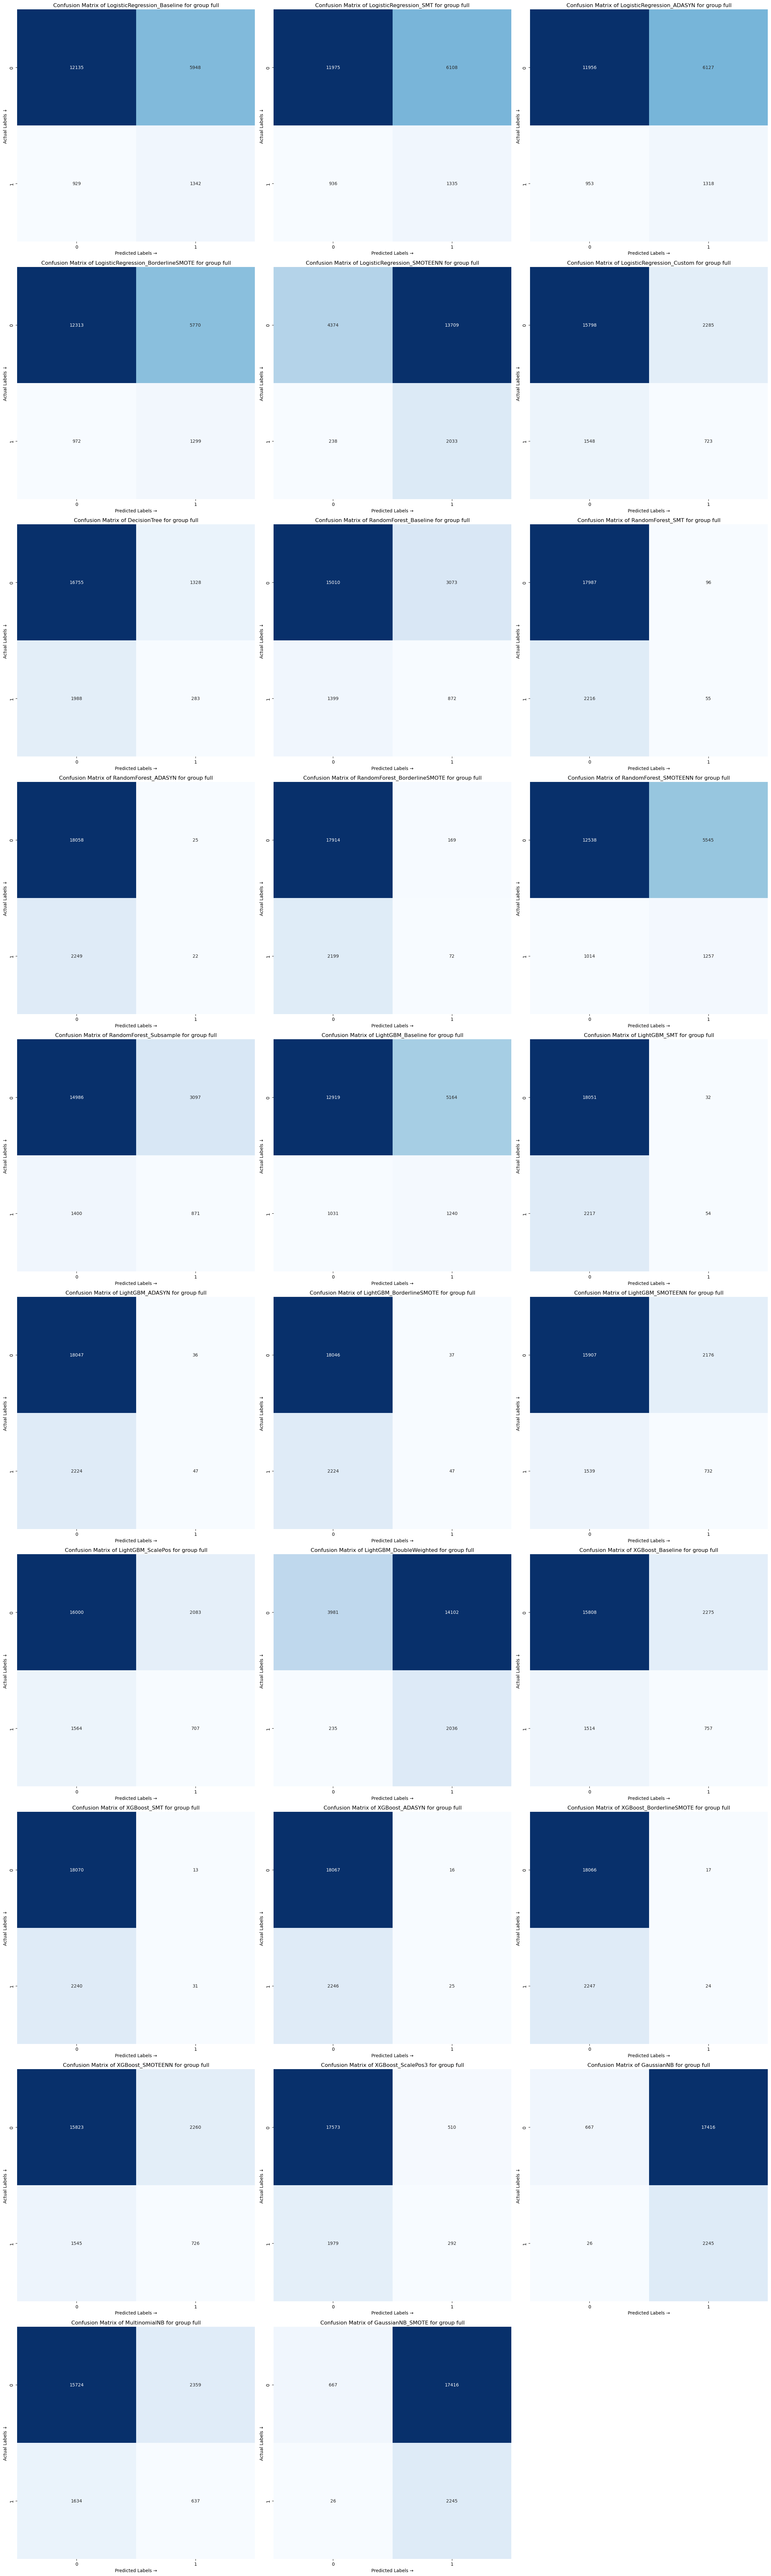

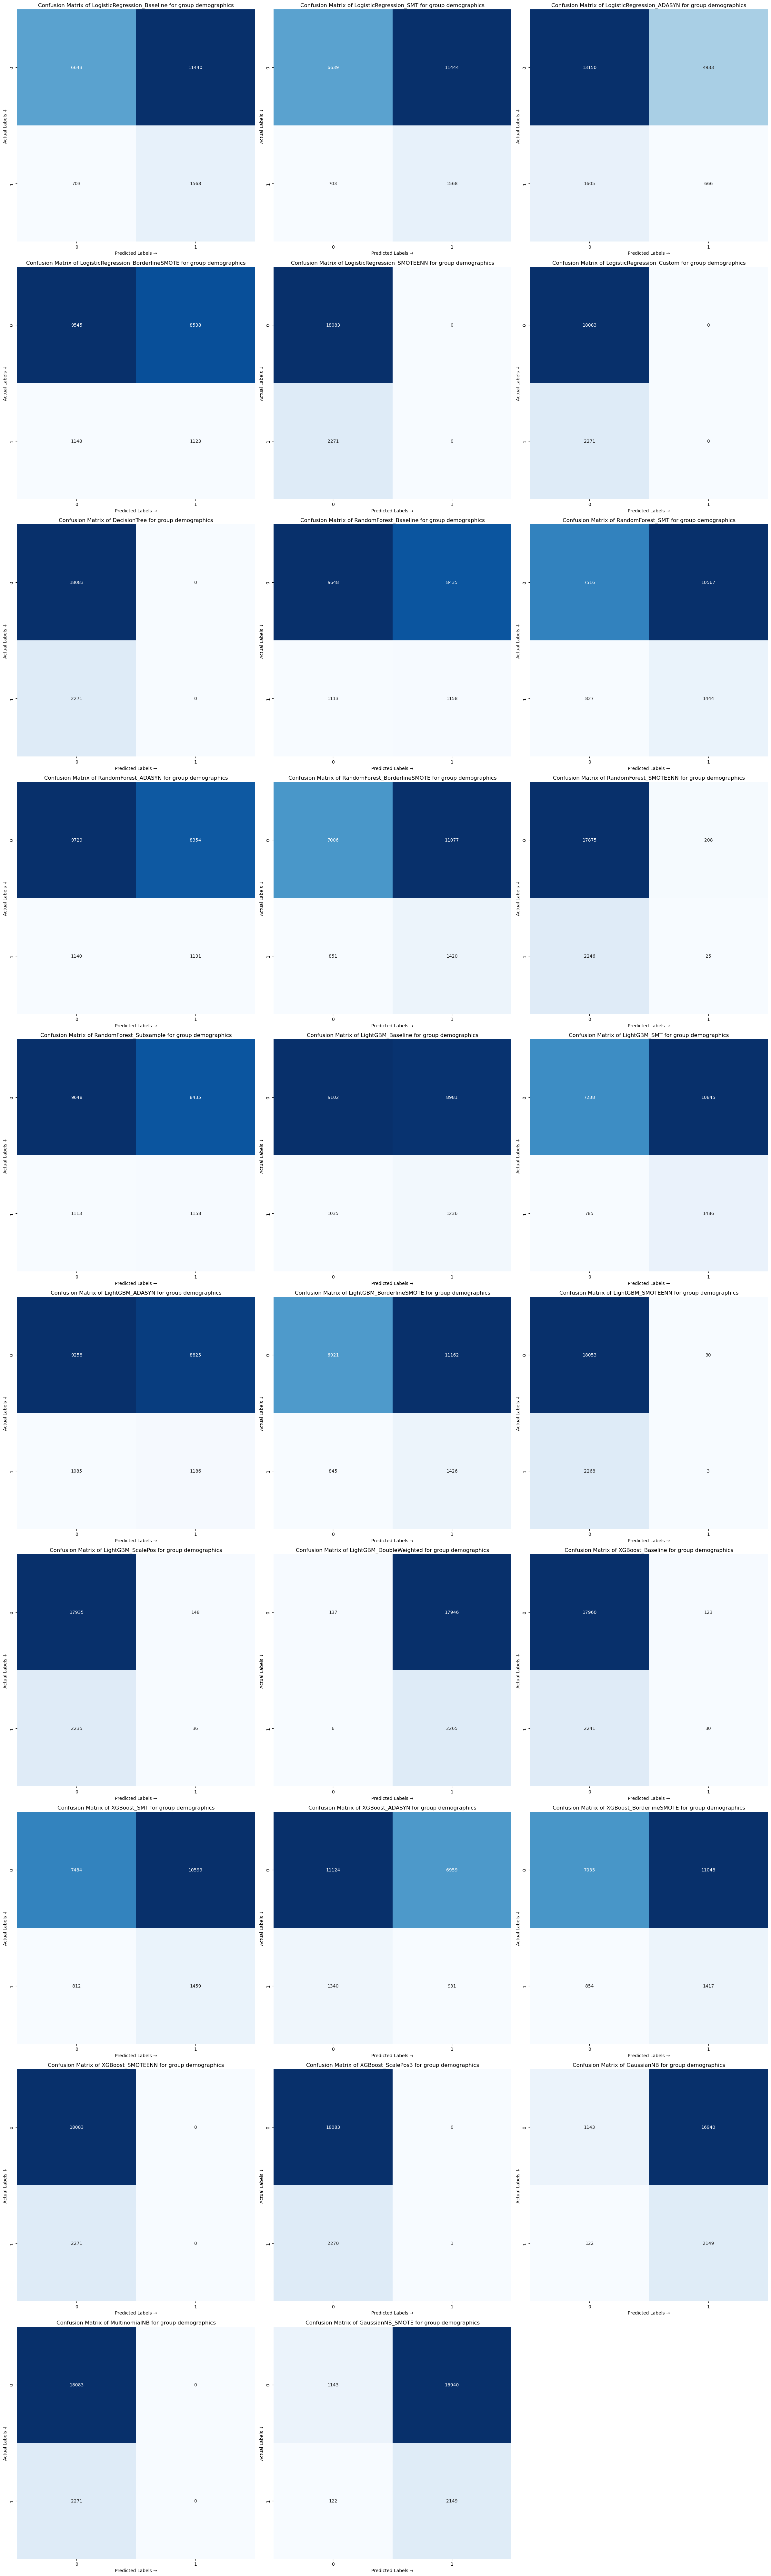

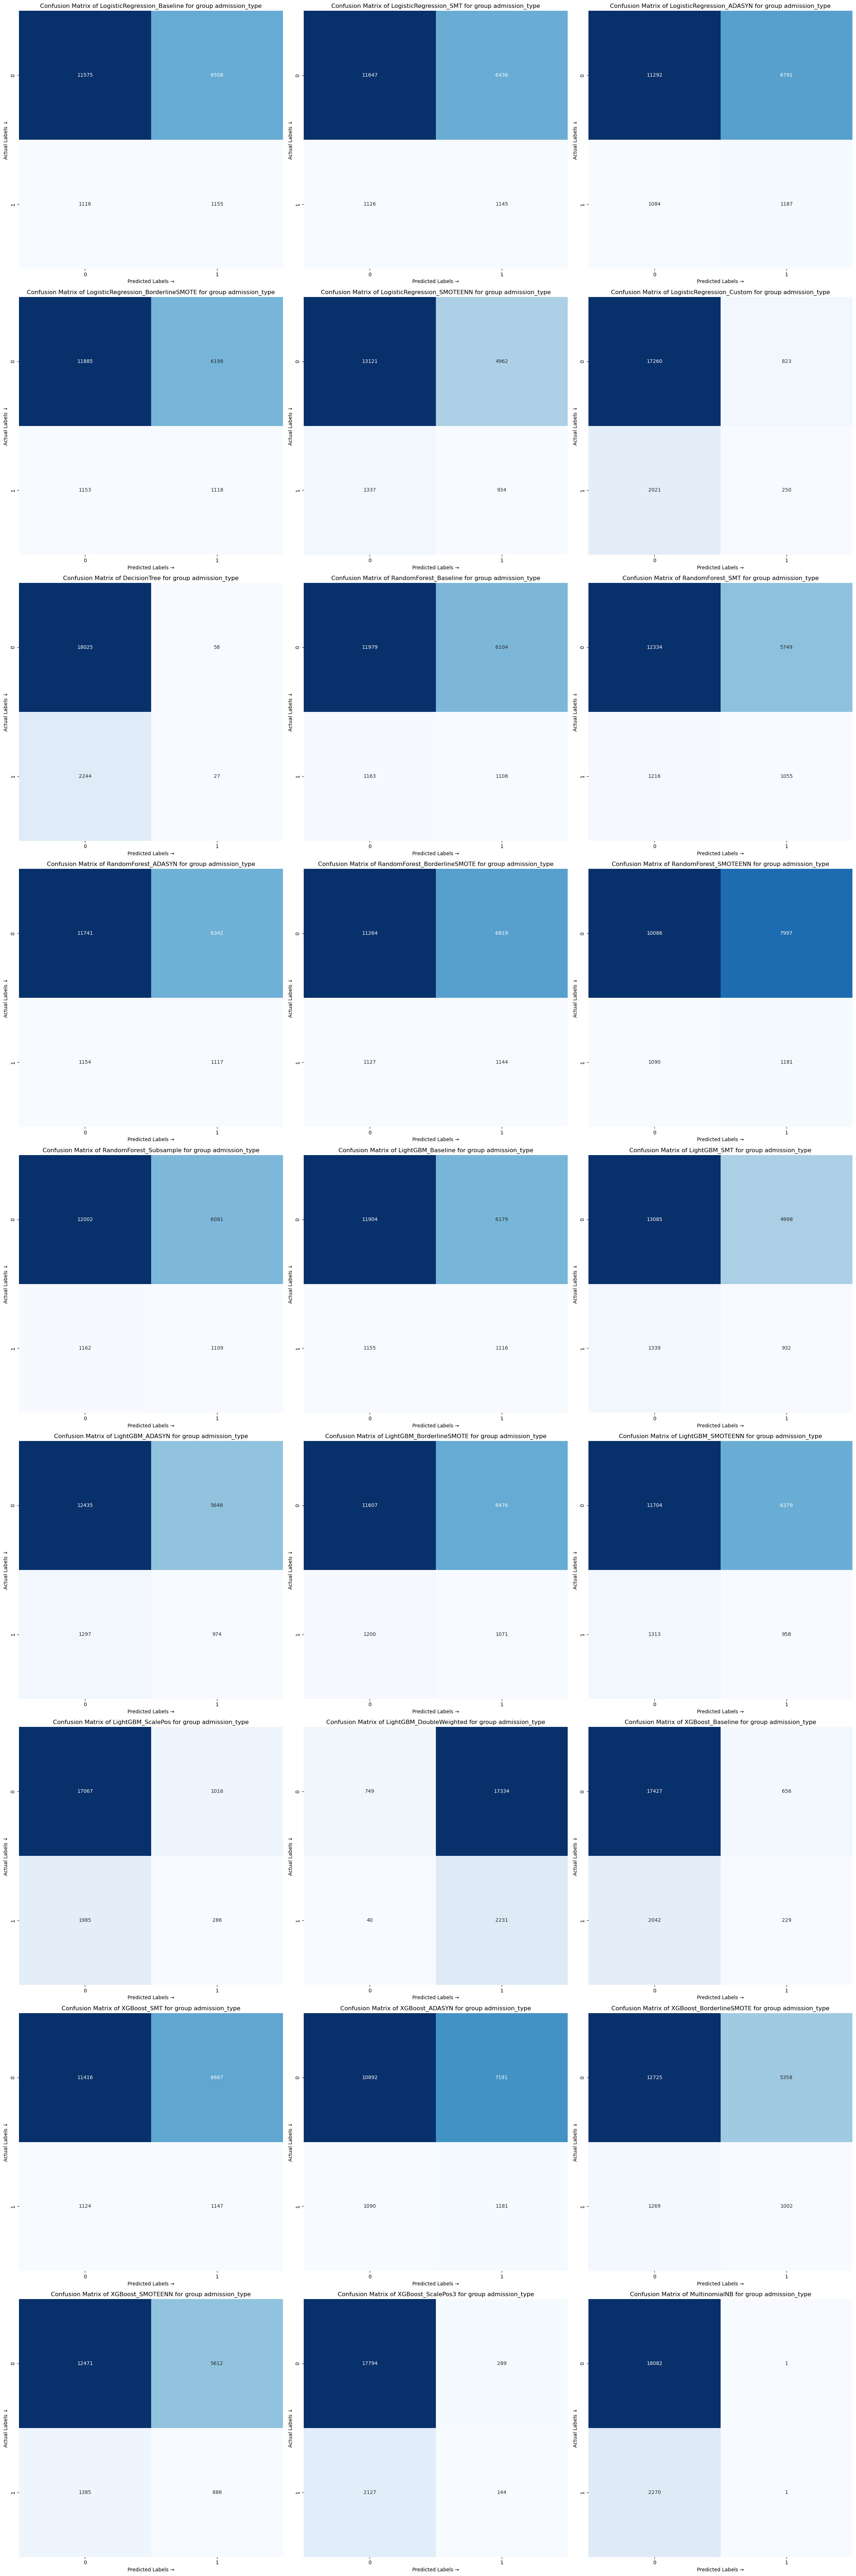

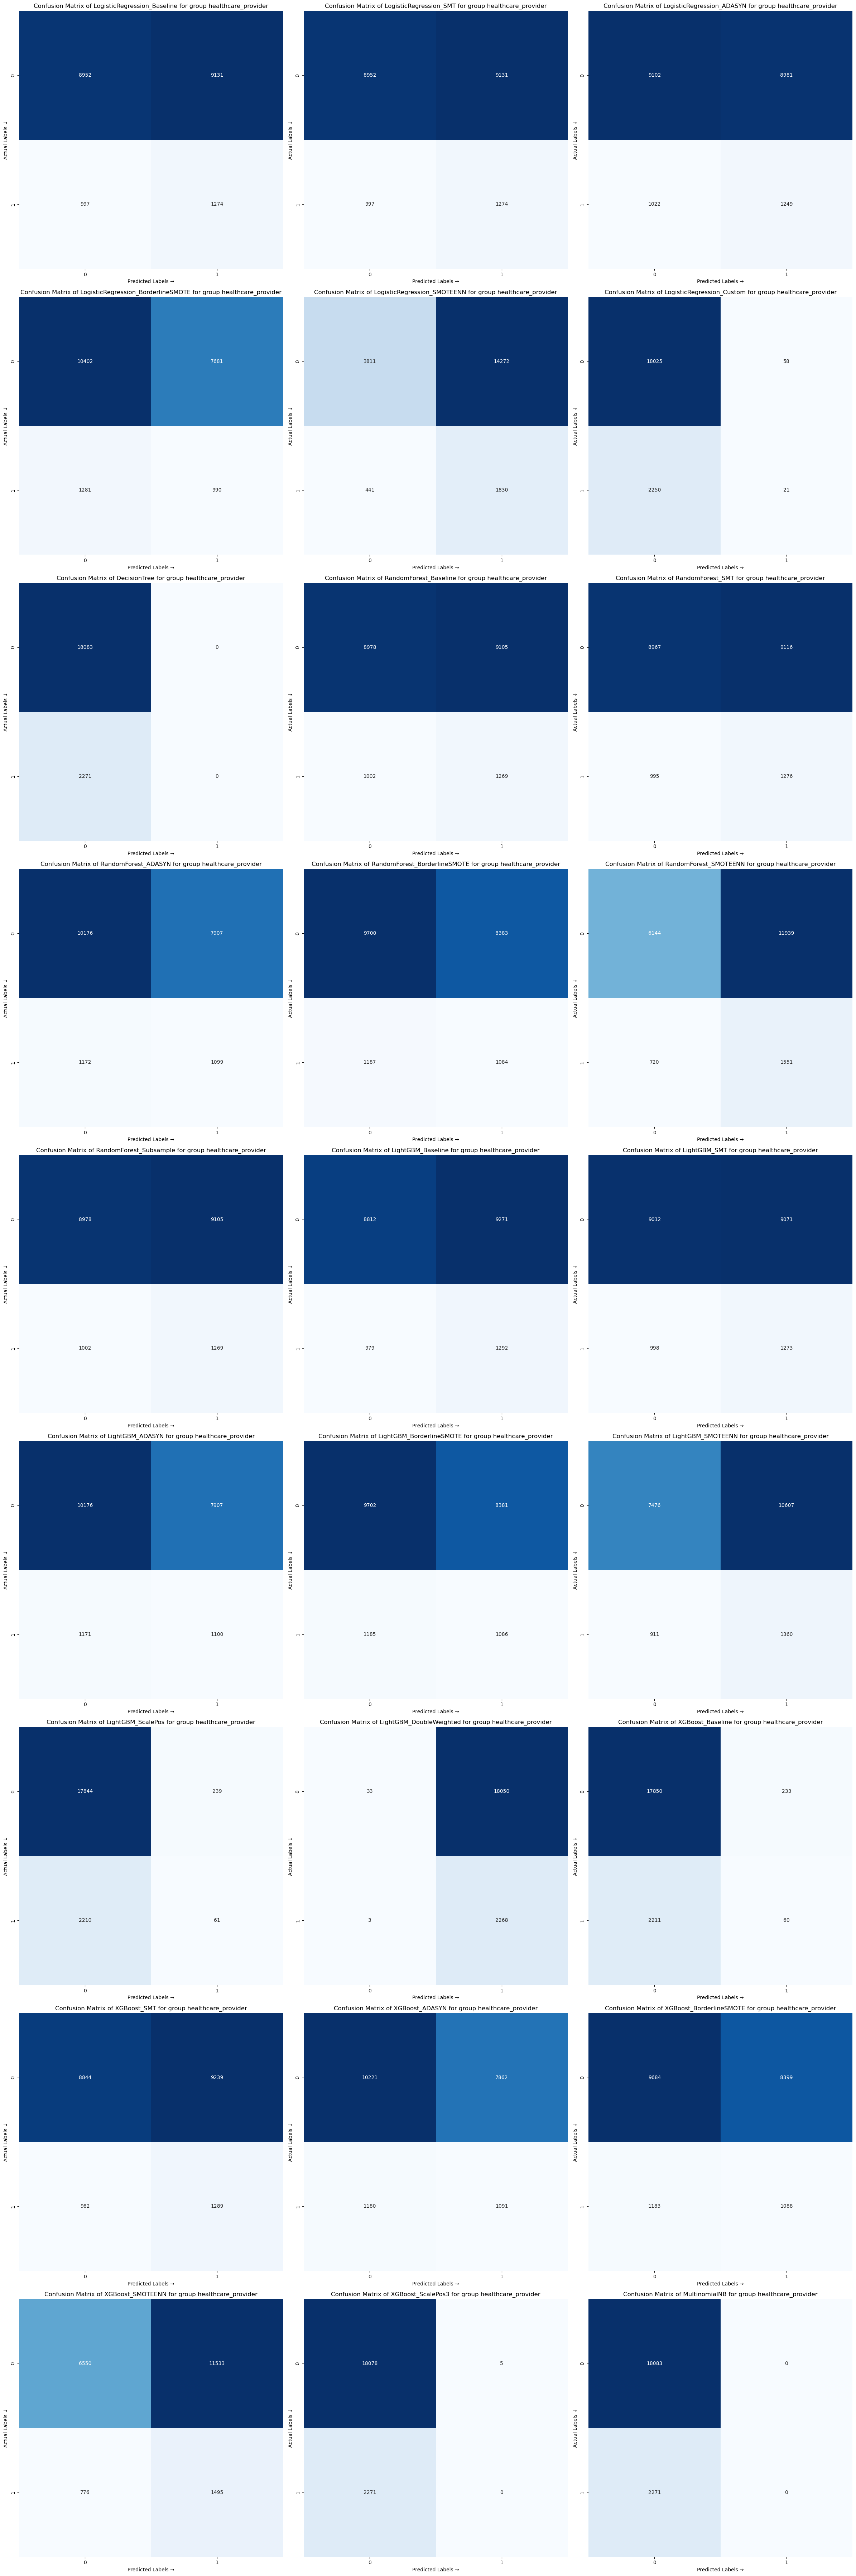

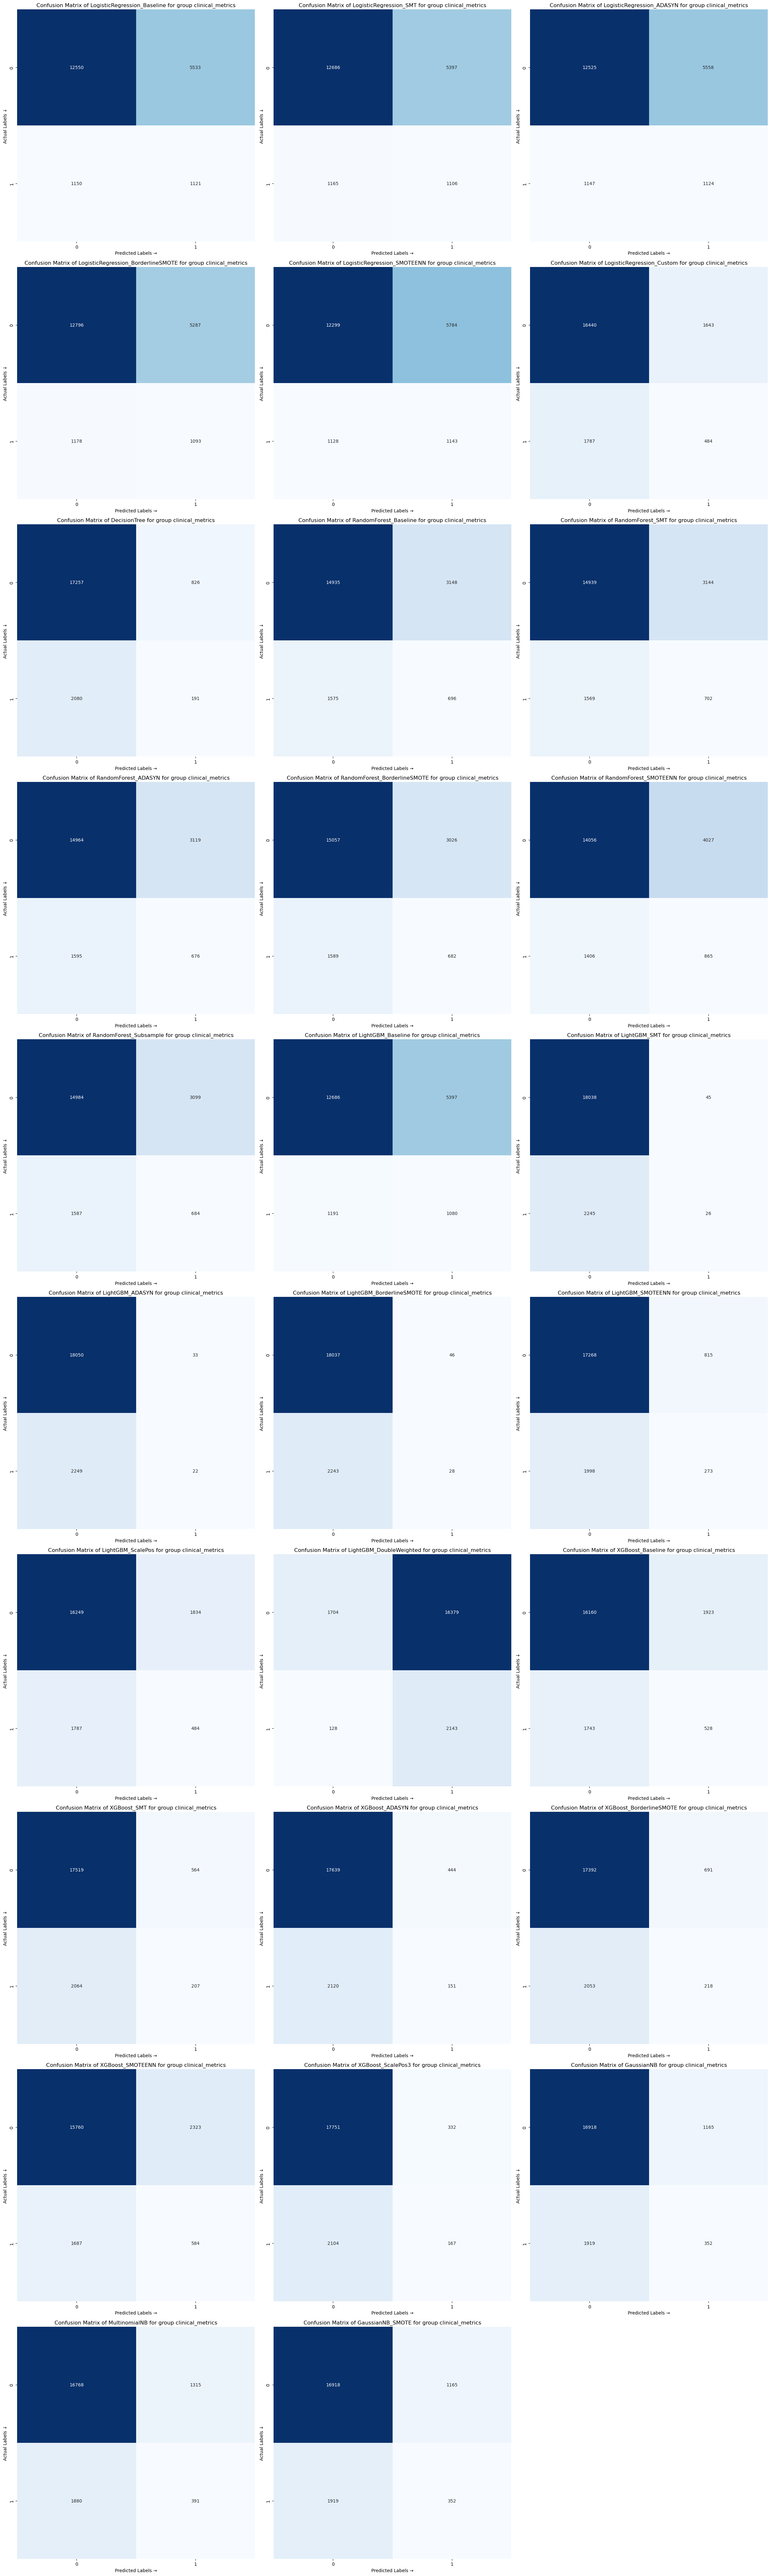

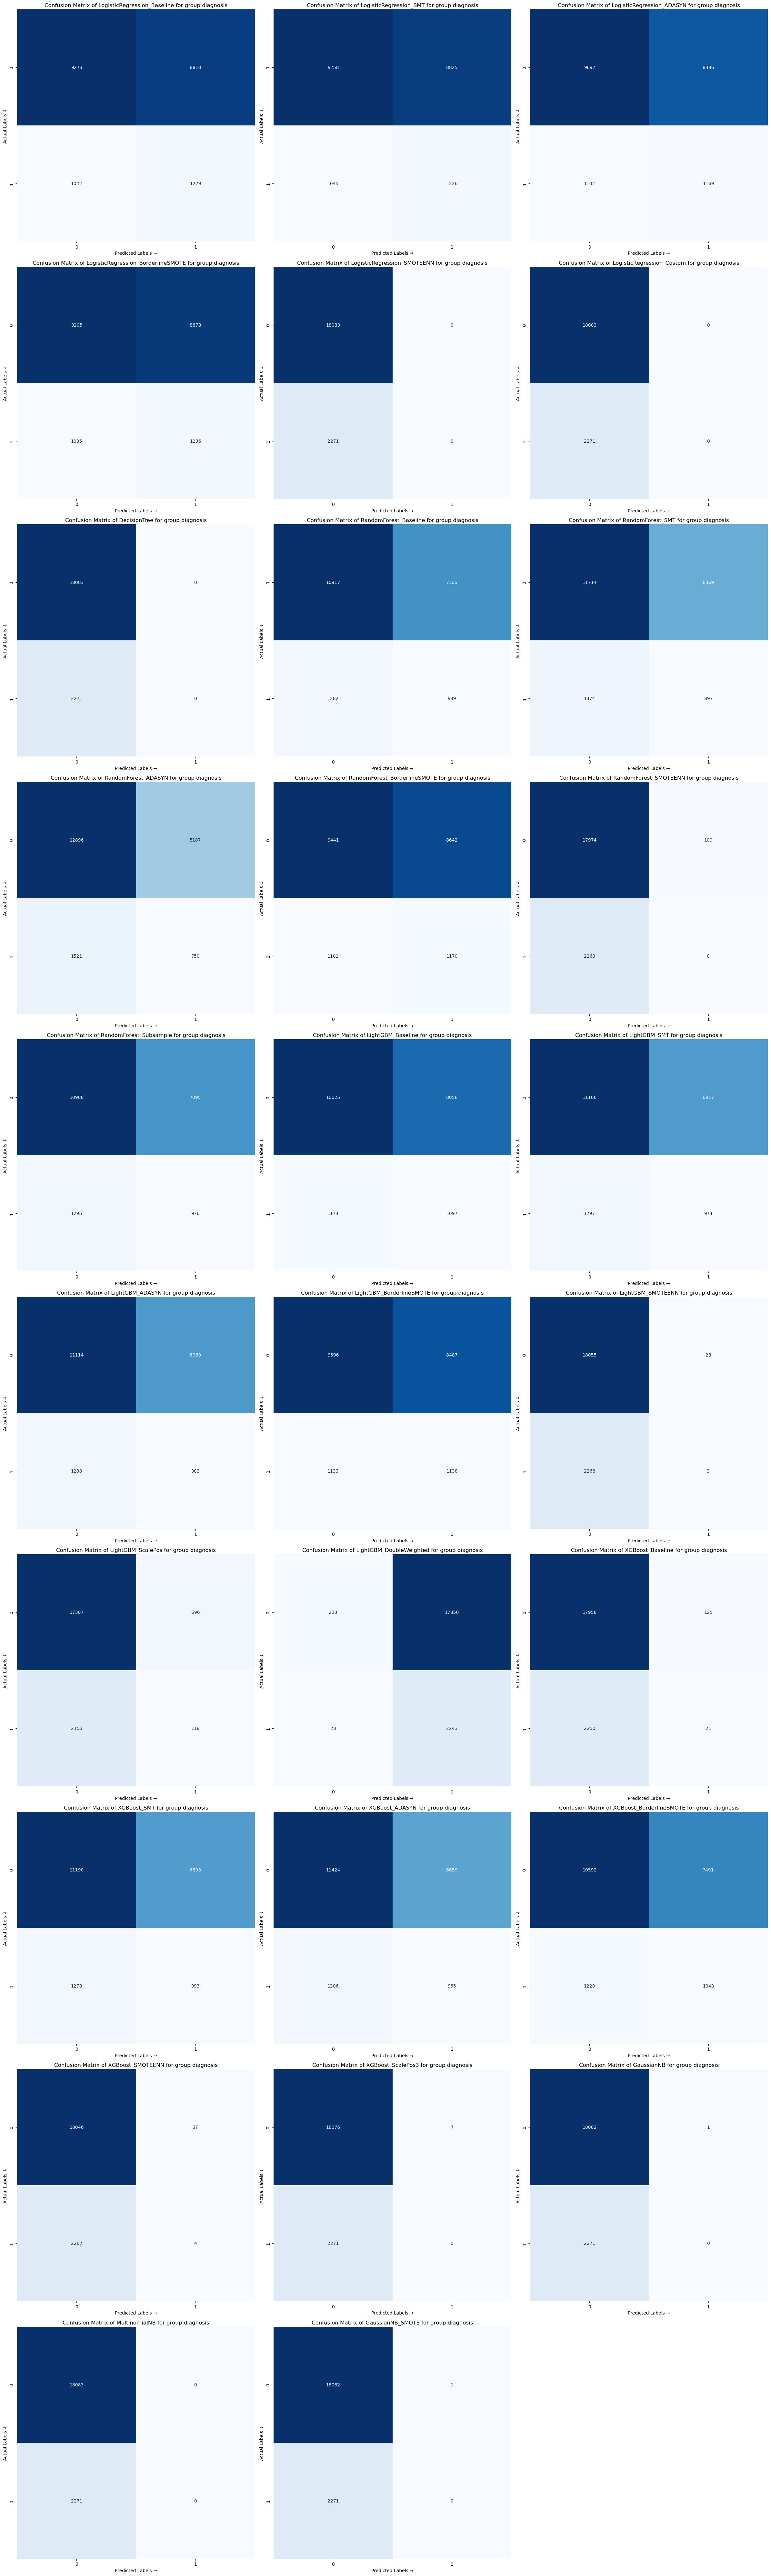

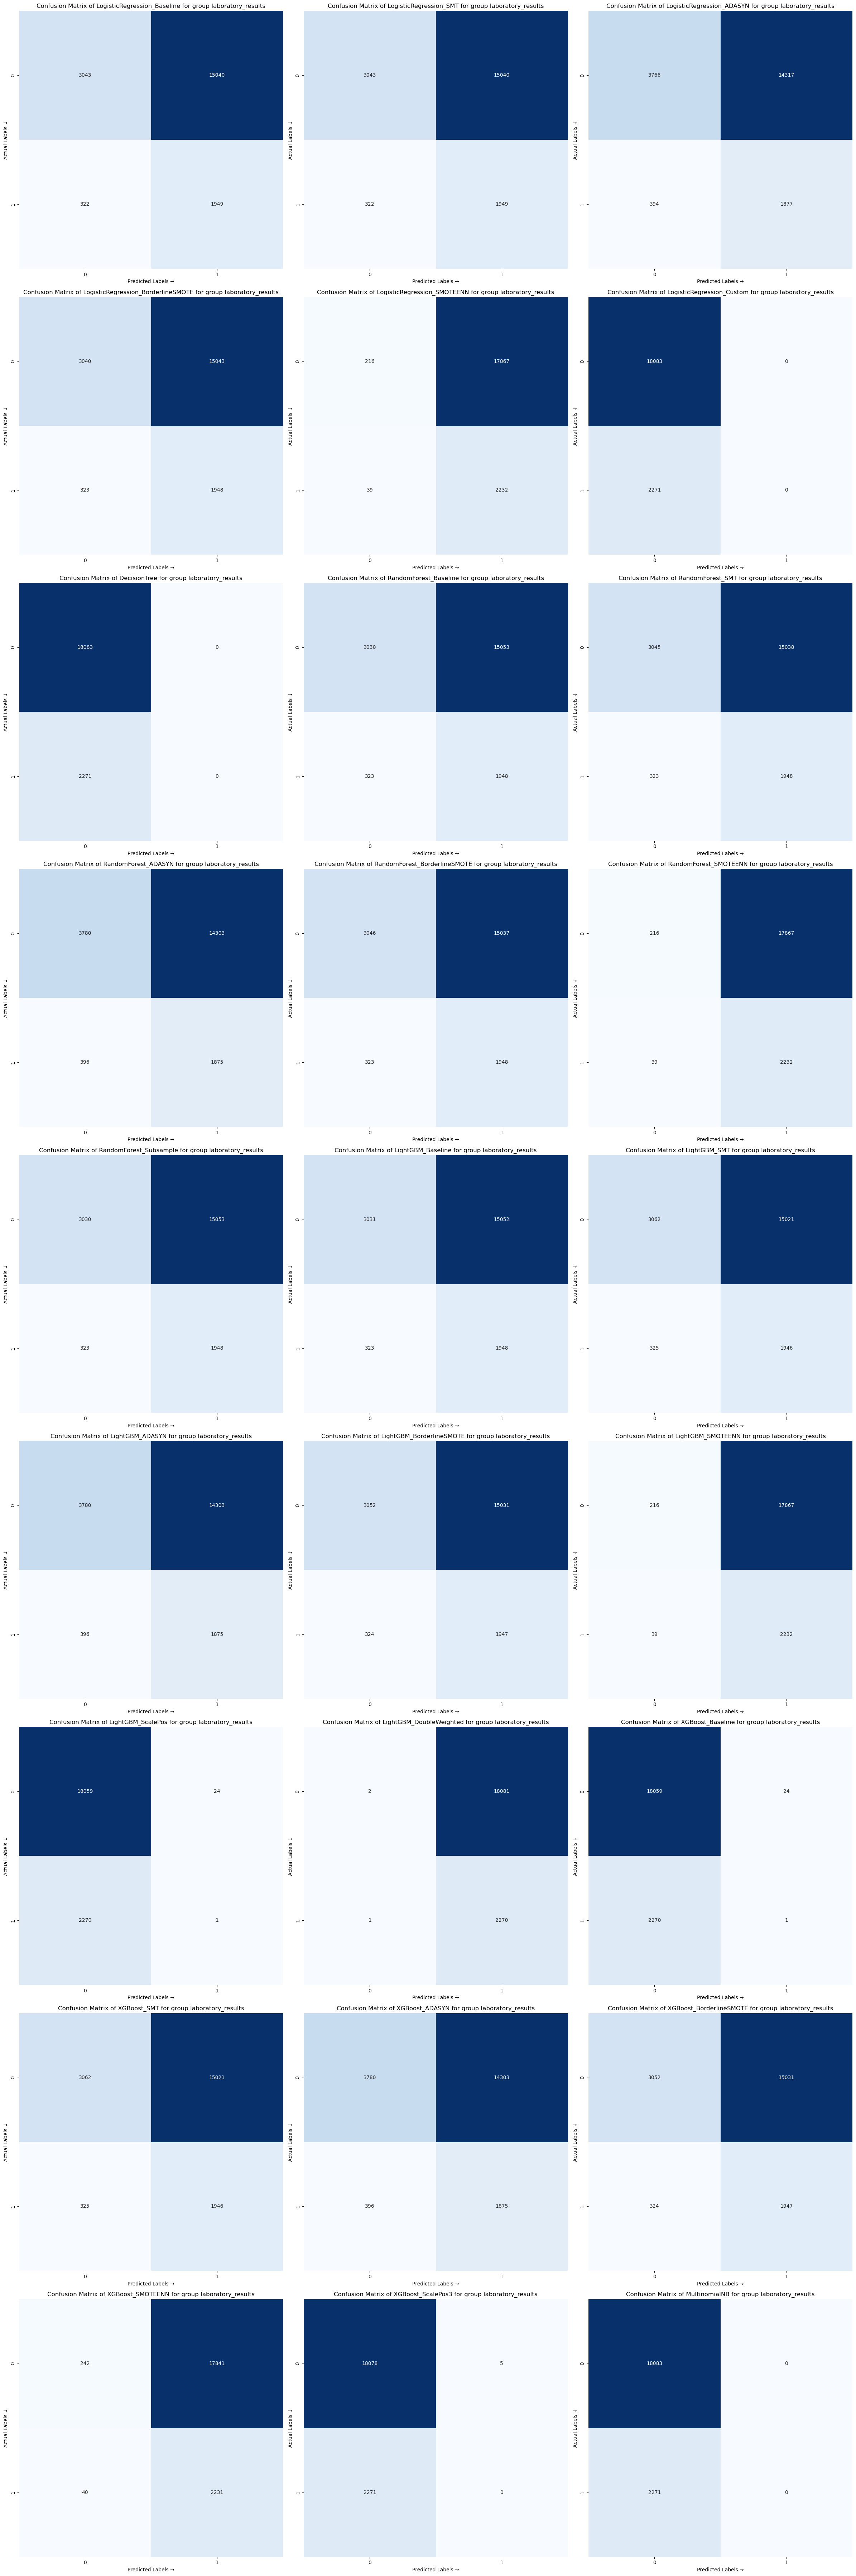

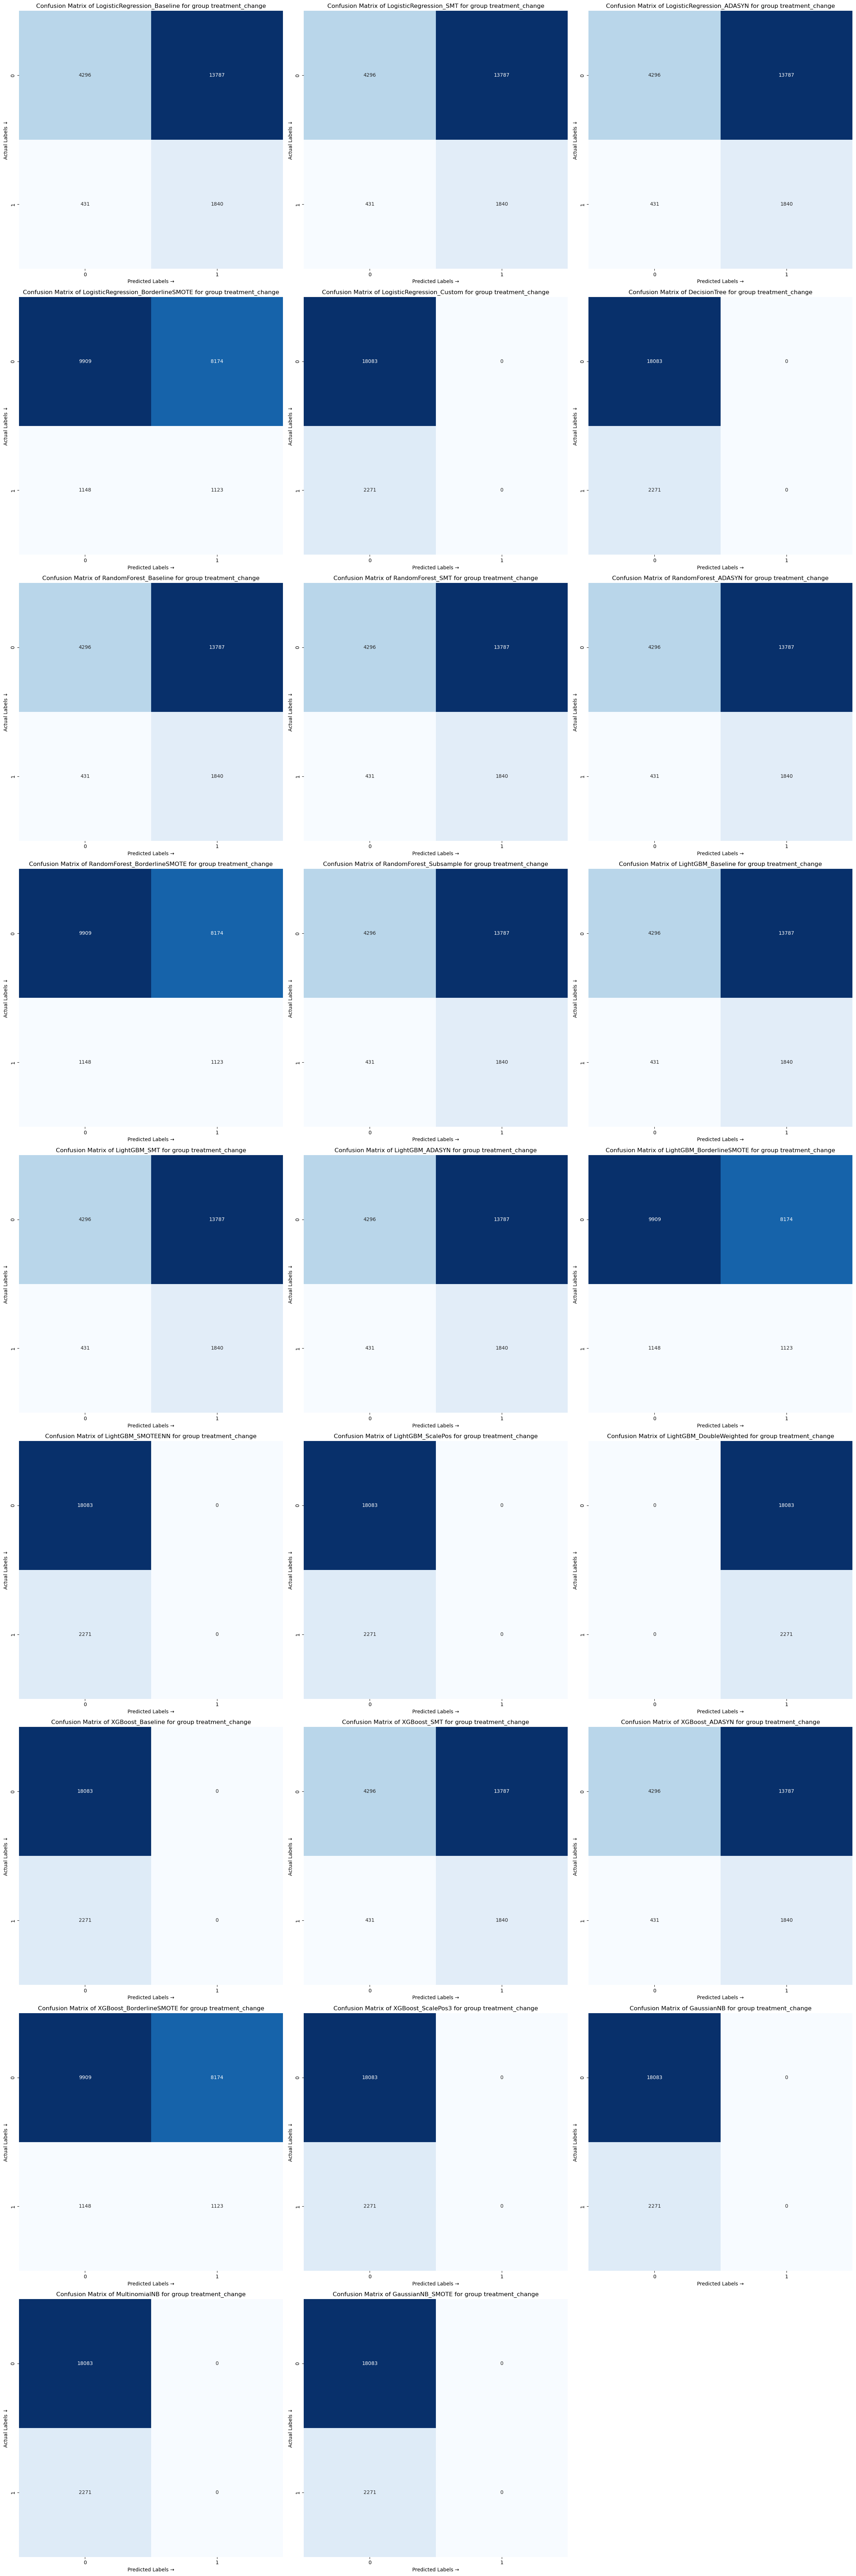

In [36]:
for group, results in evaluation_results_by_group.items():
    group_items = list(results.get_results().items())  # [(model_name, metrics), ...]
    if not group_items:
        continue

    ncols = 3
    nrows = max(1, int(np.ceil(len(group_items) / ncols)))
    fig, axes = plt.subplots(nrows, ncols, figsize=(8 * ncols, 8 * nrows))

    # normalize axes to 1D array for consistent indexing
    axes_flat = np.ravel(axes)

    for idx, (model_name, metrics) in enumerate(group_items):
        cm = np.array(metrics['confusion_matrix'])
        ax = axes_flat[idx]
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax)
        ax.set_title(f'Confusion Matrix of {model_name} for group {group}')
        ax.set_xlabel("Predicted Labels →")
        ax.set_ylabel("Actual Labels ↓")

    # turn off any unused axes
    for j in range(len(group_items), axes_flat.size):
        axes_flat[j].axis('off')

    plt.tight_layout()
    plt.show()



### Overall Accuracy

In [37]:
rows = []

df_accuracy_scores = pd.DataFrame()
for group, results in evaluation_results_by_group.items():
    group_items = list(results.get_results().items())
    tmpdict = {"group": group}
    for model_name, metrics in group_items:
        accuracy = metrics['classification_report']['accuracy']
        tmpdict[model_name] = accuracy
    rows.append(tmpdict)

df_accuracy_scores = pd.DataFrame(rows)
df_accuracy_scores = df_accuracy_scores.set_index('group')
print("Accuracy-scores for positive class (readmitted <30 days):")
df_accuracy_scores

Accuracy-scores for positive class (readmitted <30 days):


LogisticRegression_Baseline  LogisticRegression_SMT  \
group                                                                      
full                                    0.662130                0.653926   
demographics                            0.403410                0.403213   
admission_type                          0.625430                0.628476   
healthcare_provider                     0.502407                0.502407   
clinical_metrics                        0.671662                0.677606   
diagnosis                               0.515967                0.515083   
laboratory_results                      0.245259                0.245259   
treatment_change                        0.301464                0.301464   

                     LogisticRegression_ADASYN  \
group                                            
full                                  0.652157   
demographics                          0.678785   
admission_type                        0.613098   
healthcare_provider                   0.508549   
clinical_metrics                      0.670581   
diagnosis                             0.533851   
laboratory_results                    0.277243   
treatment_change                      0.301464   

                     LogisticRegression_BorderlineSMOTE  \
group                                                     
full                                           0.668763   
demographics                                   0.524123   
admission_type                                 0.638842   
healthcare_provider                            0.559693   
clinical_metrics                               0.682372   
diagnosis                                      0.512970   
laboratory_results                             0.245062   
treatment_change                               0.542006   

                     LogisticRegression_SMOTEENN  LogisticRegression_Custom  \
group                                                                         
full                                    0.314778                   0.811683   
demographics                            0.888425                   0.888425   
admission_type                          0.690528                   0.860273   
healthcare_provider                     0.277145                   0.886607   
clinical_metrics                        0.660411                   0.831483   
diagnosis                               0.888425                   0.888425   
laboratory_results                      0.120271                   0.888425   
treatment_change                             NaN                   0.888425   

                     DecisionTree  RandomForest_Baseline  RandomForest_SMT  \
group                                                                        
full                     0.837084               0.780289          0.886411   
demographics             0.888425               0.530903          0.440208   
admission_type           0.886902               0.642969          0.657807   
healthcare_provider      0.888425               0.503439          0.503243   
clinical_metrics         0.857227               0.767957          0.768448   
diagnosis                0.888425               0.584946          0.619583   
laboratory_results       0.888425               0.244571          0.245308   
treatment_change         0.888425               0.301464          0.301464   

                     RandomForest_ADASYN  RandomForest_BorderlineSMOTE  \
group                                                                    
full                            0.888277                      0.883659   
demographics                    0.533556                      0.413973   
admission_type                  0.631719                      0.609610   
healthcare_provider             0.553945                      0.529822   
clinical_metrics                0.768399                      0.773263   
diagnosis                       0.670433                      0.521323   
labo

### Readmitted Positive Precision Score

In [38]:
rows = []

df_positive_precision_scores = pd.DataFrame()
for group, results in evaluation_results_by_group.items():
    group_items = list(results.get_results().items())
    tmpdict = {"group": group}
    for model_name, metrics in group_items:
        metric_precision_score = metrics['classification_report']['1']['precision']
        tmpdict[model_name] = metric_precision_score
    rows.append(tmpdict)

df_positive_precision_scores = pd.DataFrame(rows)
df_positive_precision_scores = df_positive_precision_scores.set_index('group')
print("Precision-scores for positive class (readmitted <30 days):")
df_positive_precision_scores

Precision-scores for positive class (readmitted <30 days):


LogisticRegression_Baseline  LogisticRegression_SMT  \
group                                                                      
full                                    0.184088                0.179363   
demographics                            0.120541                0.120504   
admission_type                          0.150724                0.151035   
healthcare_provider                     0.122441                0.122441   
clinical_metrics                        0.168470                0.170075   
diagnosis                               0.122423                0.121978   
laboratory_results                      0.114721                0.114721   
treatment_change                        0.117745                0.117745   

                     LogisticRegression_ADASYN  \
group                                            
full                                  0.177032   
demographics                          0.118950   
admission_type                        0.148784   
healthcare_provider                   0.122092   
clinical_metrics                      0.168213   
diagnosis                             0.122344   
laboratory_results                    0.115907   
treatment_change                      0.117745   

                     LogisticRegression_BorderlineSMOTE  \
group                                                     
full                                           0.183760   
demographics                                   0.116241   
admission_type                                 0.152816   
healthcare_provider                            0.114174   
clinical_metrics                               0.171317   
diagnosis                                      0.122207   
laboratory_results                             0.114649   
treatment_change                               0.120792   

                     LogisticRegression_SMOTEENN  LogisticRegression_Custom  \
group                                                                         
full                                    0.129145                   0.240359   
demographics                            0.000000                   0.000000   
admission_type                          0.158412                   0.232992   
healthcare_provider                     0.113650                   0.265823   
clinical_metrics                        0.165006                   0.227551   
diagnosis                               0.000000                   0.000000   
laboratory_results                      0.111050                   0.000000   
treatment_change                             NaN                   0.000000   

                     DecisionTree  RandomForest_Baseline  RandomForest_SMT  \
group                                                                        
full                     0.175667               0.221039          0.364238   
demographics             0.000000               0.120713          0.120223   
admission_type           0.317647               0.153633          0.155056   
healthcare_provider      0.000000               0.122325          0.122787   
clinical_metrics         0.187807               0.181061          0.182527   
diagnosis                0.000000               0.121275          0.123452   
laboratory_results       0.000000               0.114581          0.114683   
treatment_change         0.000000               0.117745          0.117745   

                     RandomForest_ADASYN  RandomForest_BorderlineSMOTE  \
group                                                                    
full                            0.468085                      0.298755   
demographics                    0.119241                      0.113627   
admission_type                  0.149752                      0.143664   
healthcare_provider             0.122030                      0.114503   
clinical_metrics                0.178129                      0.183927   
diagnosis                       0.126326                      0.119242   
labo

### Readmitted Positive Recall Score

In [39]:
rows = []

df_positive_recall_scores = pd.DataFrame()
for group, results in evaluation_results_by_group.items():
    group_items = list(results.get_results().items())
    tmpdict = {"group": group}
    for model_name, metrics in group_items:
        metric_recall_score = metrics['classification_report']['1']['recall']
        tmpdict[model_name] = metric_recall_score
    rows.append(tmpdict)

df_positive_recall_scores = pd.DataFrame(rows)
df_positive_recall_scores = df_positive_recall_scores.set_index('group')
print("Recall-scores for positive class (readmitted <30 days):")
df_positive_recall_scores

Recall-scores for positive class (readmitted <30 days):


LogisticRegression_Baseline  LogisticRegression_SMT  \
group                                                                      
full                                    0.590929                0.587847   
demographics                            0.690445                0.690445   
admission_type                          0.508587                0.504183   
healthcare_provider                     0.560986                0.560986   
clinical_metrics                        0.493615                0.487010   
diagnosis                               0.541171                0.539850   
laboratory_results                      0.858212                0.858212   
treatment_change                        0.810216                0.810216   

                     LogisticRegression_ADASYN  \
group                                            
full                                  0.580361   
demographics                          0.293263   
admission_type                        0.522677   
healthcare_provider                   0.549978   
clinical_metrics                      0.494936   
diagnosis                             0.514751   
laboratory_results                    0.826508   
treatment_change                      0.810216   

                     LogisticRegression_BorderlineSMOTE  \
group                                                     
full                                           0.571995   
demographics                                   0.494496   
admission_type                                 0.492294   
healthcare_provider                            0.435931   
clinical_metrics                               0.481286   
diagnosis                                      0.544254   
laboratory_results                             0.857772   
treatment_change                               0.494496   

                     LogisticRegression_SMOTEENN  LogisticRegression_Custom  \
group                                                                         
full                                    0.895200                   0.318362   
demographics                            0.000000                   0.000000   
admission_type                          0.411273                   0.110084   
healthcare_provider                     0.805812                   0.009247   
clinical_metrics                        0.503303                   0.213122   
diagnosis                               0.000000                   0.000000   
laboratory_results                      0.982827                   0.000000   
treatment_change                             NaN                   0.000000   

                     DecisionTree  RandomForest_Baseline  RandomForest_SMT  \
group                                                                        
full                     0.124615               0.383972          0.024218   
demographics             0.000000               0.509908          0.635843   
admission_type           0.011889               0.487891          0.464553   
healthcare_provider      0.000000               0.558785          0.561867   
clinical_metrics         0.084104               0.306473          0.309115   
diagnosis                0.000000               0.435491          0.394980   
laboratory_results       0.000000               0.857772          0.857772   
treatment_change         0.000000               0.810216          0.810216   

                     RandomForest_ADASYN  RandomForest_BorderlineSMOTE  \
group                                                                    
full                            0.009687                      0.031704   
demographics                    0.498018                      0.625275   
admission_type                  0.491854                      0.503743   
healthcare_provider             0.483928                      0.477323   
clinical_metrics                0.297666                      0.300308   
diagnosis                       0.330251                      0.515192   
labo

### Readmitted Positive F1 Score

In [40]:
rows = []

df_positive_f1_scores = pd.DataFrame()
for group, results in evaluation_results_by_group.items():
    group_items = list(results.get_results().items())
    tmpdict = {"group": group}
    for model_name, metrics in group_items:
        f1_score = metrics['classification_report']['1']['f1-score']
        tmpdict[model_name] = f1_score
    rows.append(tmpdict)

df_positive_f1_scores = pd.DataFrame(rows)
df_positive_f1_scores = df_positive_f1_scores.set_index('group')
print("F1-scores for positive class (readmitted <30 days):")
df_positive_f1_scores

F1-scores for positive class (readmitted <30 days):


LogisticRegression_Baseline  LogisticRegression_SMT  \
group                                                                      
full                                    0.280724                0.274861   
demographics                            0.205249                0.205195   
admission_type                          0.232535                0.232440   
healthcare_provider                     0.201010                0.201010   
clinical_metrics                        0.251204                0.252109   
diagnosis                               0.199675                0.198994   
laboratory_results                      0.202388                0.202388   
treatment_change                        0.205610                0.205610   

                     LogisticRegression_ADASYN  \
group                                            
full                                  0.271305   
demographics                          0.169250   
admission_type                        0.231632   
healthcare_provider                   0.199824   
clinical_metrics                      0.251089   
diagnosis                             0.197700   
laboratory_results                    0.203304   
treatment_change                      0.205610   

                     LogisticRegression_BorderlineSMOTE  \
group                                                     
full                                           0.278158   
demographics                                   0.188233   
admission_type                                 0.233233   
healthcare_provider                            0.180954   
clinical_metrics                               0.252688   
diagnosis                                      0.199596   
laboratory_results                             0.202264   
treatment_change                               0.194156   

                     LogisticRegression_SMOTEENN  LogisticRegression_Custom  \
group                                                                         
full                                    0.225726                   0.273916   
demographics                            0.000000                   0.000000   
admission_type                          0.228725                   0.149522   
healthcare_provider                     0.199205                   0.017872   
clinical_metrics                        0.248532                   0.220100   
diagnosis                               0.000000                   0.000000   
laboratory_results                      0.199553                   0.000000   
treatment_change                             NaN                   0.000000   

                     DecisionTree  RandomForest_Baseline  RandomForest_SMT  \
group                                                                        
full                     0.145801               0.280566          0.045417   
demographics             0.000000               0.195212          0.202213   
admission_type           0.022920               0.233681          0.232507   
healthcare_provider      0.000000               0.200712          0.201532   
clinical_metrics         0.116180               0.227637          0.229524   
diagnosis                0.000000               0.189718          0.188109   
laboratory_results       0.000000               0.202159          0.202316   
treatment_change         0.000000               0.205610          0.205610   

                     RandomForest_ADASYN  RandomForest_BorderlineSMOTE  \
group                                                                    
full                            0.018982                      0.057325   
demographics                    0.192412                      0.192308   
admission_type                  0.229599                      0.223568   
healthcare_provider             0.194910                      0.184699   
clinical_metrics                0.222882                      0.228132   
diagnosis                       0.182749                      0.193661   
labo

In [41]:
rows = []

df_roc_scores = pd.DataFrame()
for group, results in evaluation_results_by_group.items():
    group_items = list(results.get_results().items())
    tmpdict = {"group": group}
    for model_name, metrics in group_items:
        roc_auc = metrics['roc_auc']
        tmpdict[model_name] = roc_auc
    rows.append(tmpdict)

df_roc_scores = pd.DataFrame(rows)
df_roc_scores = df_roc_scores.set_index('group')
print("ROC AUC scores:")
df_roc_scores

ROC AUC scores:


LogisticRegression_Baseline  LogisticRegression_SMT  \
group                                                                      
full                                    0.677166                0.669318   
demographics                            0.530299                0.530278   
admission_type                          0.602069                0.601063   
healthcare_provider                     0.528794                0.529045   
clinical_metrics                        0.633503                0.632775   
diagnosis                               0.540585                0.541016   
laboratory_results                      0.511077                0.510853   
treatment_change                        0.529283                0.529283   

                     LogisticRegression_ADASYN  \
group                                            
full                                  0.666463   
demographics                          0.525539   
admission_type                        0.600289   
healthcare_provider                   0.526973   
clinical_metrics                      0.632815   
diagnosis                             0.539091   
laboratory_results                    0.518960   
treatment_change                      0.529283   

                     LogisticRegression_BorderlineSMOTE  \
group                                                     
full                                           0.671225   
demographics                                   0.522961   
admission_type                                 0.600450   
healthcare_provider                            0.503272   
clinical_metrics                               0.631400   
diagnosis                                      0.540067   
laboratory_results                             0.511203   
treatment_change                               0.529283   

                     LogisticRegression_SMOTEENN  LogisticRegression_Custom  \
group                                                                         
full                                    0.674536                   0.676873   
demographics                            0.473967                   0.530311   
admission_type                          0.593092                   0.602124   
healthcare_provider                     0.514307                   0.528995   
clinical_metrics                        0.631496                   0.633490   
diagnosis                               0.515575                   0.540632   
laboratory_results                      0.514632                   0.511077   
treatment_change                             NaN                   0.529283   

                     DecisionTree  RandomForest_Baseline  RandomForest_SMT  \
group                                                                        
full                     0.551871               0.676510          0.659772   
demographics             0.539071               0.538567          0.534119   
admission_type           0.580047               0.598427          0.598359   
healthcare_provider      0.533358               0.533212          0.531782   
clinical_metrics         0.525327               0.604089          0.593447   
diagnosis                0.521206               0.533389          0.532840   
laboratory_results       0.510115               0.510064          0.510908   
treatment_change         0.529283               0.529283          0.529283   

                     RandomForest_ADASYN  RandomForest_BorderlineSMOTE  \
group                                                                    
full                            0.659578                      0.663239   
demographics                    0.528988                      0.524468   
admission_type                  0.589699                      0.587453   
healthcare_provider             0.532048                      0.525229   
clinical_metrics                0.591801                      0.595192   
diagnosis                       0.533557                      0.523774   
labo

### ROC Curves For Model Comparison

Analysis: All Naive Bayes models can be removed, as their performance is close to that of a random classifier.

[LightGBM] [Info] Number of positive: 9086, number of negative: 72326
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018942 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1175
[LightGBM] [Info] Number of data points in the train set: 81412, number of used features: 106
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 9086, number of negative: 72326
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018587 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1175
[LightGBM] [Info] Number of data points in the train set: 81412, number of used features: 106
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111605 -> initscore=-2.074449
[LightGBM] [Info] Start training from score -2.074449


c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 9086, number of negative: 72326
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019032 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1175
[LightGBM] [Info] Number of data points in the train set: 81412, number of used features: 106
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111605 -> initscore=-2.074449
[LightGBM] [Info] Start training from score -2.074449


c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 72326, number of negative: 72326
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.100448 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 24464
[LightGBM] [Info] Number of data points in the train set: 144652, number of used features: 109
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 72326, number of negative: 72326
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.354662 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 24464
[LightGBM] [Info] Number of data points in the train set: 144652, number of used features: 109
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 9086, number of negative: 72326
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031259 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1175
[LightGBM] [Info] Number of data points in the train set: 81412, number of used features: 106
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111605 -> initscore=-2.074449
[LightGBM] [Info] Start training from score -2.074449


c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 9086, number of negative: 72326
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019304 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1175
[LightGBM] [Info] Number of data points in the train set: 81412, number of used features: 106
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\xianj\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [14:56:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\xianj\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [14:56:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\xianj\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [14:56:27] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\xianj\anaconda3\Lib\site-pa

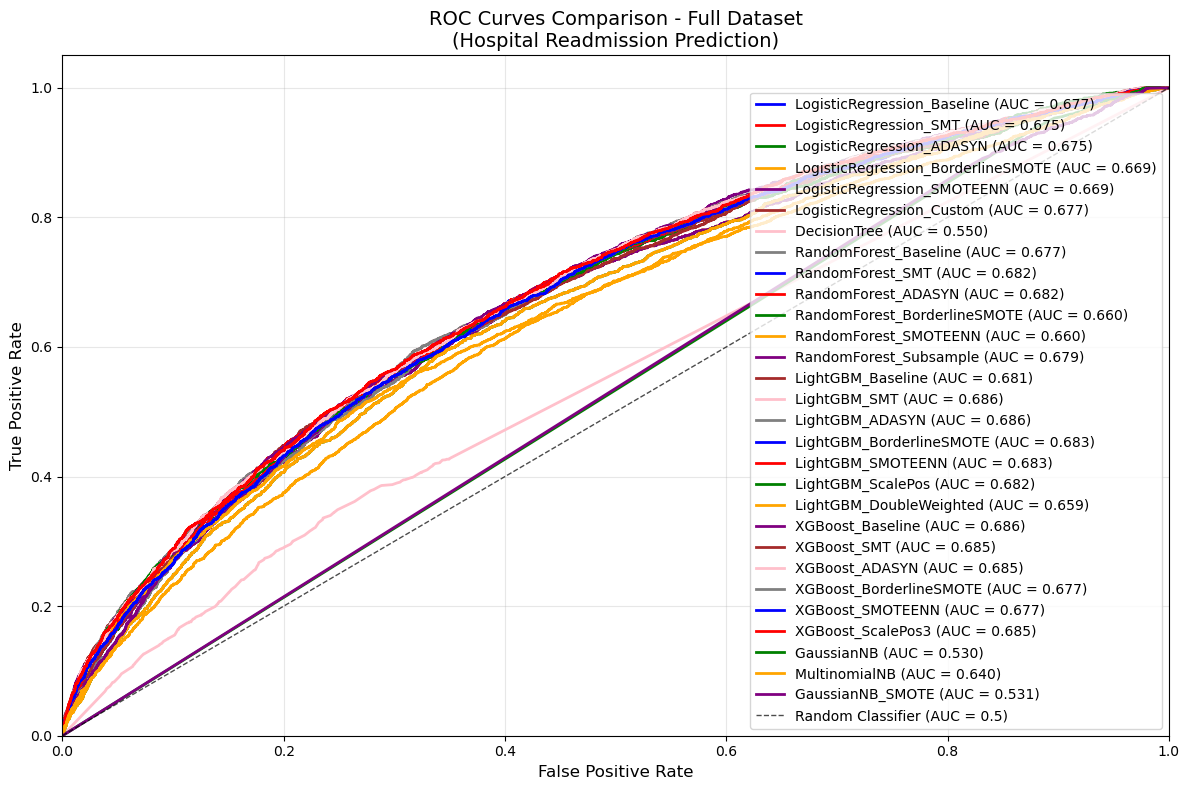

In [48]:
# Simple ROC curves for 'full' dataset only
def plot_roc_full_dataset():
    plt.figure(figsize=(12, 8))
    
    dataset = data_preprocessed_by_group['full']
    colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray']
    
    for idx, (name, model) in enumerate(models.items()):
        # Prepare pipeline
        if "SMOTE" in name:
            smote = SMOTE(random_state=42)
            pipe = ImbPipeline(steps=[('smote', smote), ('clf', model)])
        elif "MultinomialNB" in name:
            pipe = Pipeline(steps=[("ensure_non_negative", EnsureNonNegative()), ("clf", model)])
        else:
            pipe = Pipeline(steps=[("clf", model)])
        
        try:
            # Fit and predict
            pipe.fit(dataset["x_train_preprocessed"], dataset["y_train"])
            y_proba = pipe.predict_proba(dataset["x_test_preprocessed"])[:, 1]
            
            # Calculate ROC curve
            fpr, tpr, _ = roc_curve(dataset["y_test"], y_proba)
            auc_score = roc_auc_score(dataset["y_test"], y_proba)
            
            # Plot
            color = colors[idx % len(colors)]
            plt.plot(fpr, tpr, linewidth=2, 
                    label=f'{name} (AUC = {auc_score:.3f})', 
                    color=color)
            
        except Exception as e:
            print(f"Error with {name}: {e}")
    
    # Add diagonal line for random classifier
    plt.plot([0, 1], [0, 1], 'k--', linewidth=1, alpha=0.7, 
             label='Random Classifier (AUC = 0.5)')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('ROC Curves Comparison - Full Dataset\n(Hospital Readmission Prediction)', fontsize=14)
    plt.legend(loc="lower right", fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Run the simple version
plot_roc_full_dataset()


# **Threshold Optimization for Selected Models**

## Overview Threshold Optimization

**Purpose**: Optimize decision thresholds for the best-performing models to maximize clinical utility in hospital readmission prediction.
In clinical settings, the default 0.5 probability threshold may not be the best because:
1. **Class Imbalance Impact**: Hospital readmissions are naturally imbalanced (~11% positive cases)
2. **Resource Allocation**: Hospitals have limited resources for preventive interventions

### **Optimization Framework**

#### **Model Selection Strategy**:
- **Multi-metric Ranking**: Prioritize by ROC AUC → Precision → F1-score for robust selection
- **Clinical Relevance**: Focus on models that demonstrate good performance
- **Top-K Selection**: Analyze the 5 best-performing models for detailed threshold optimization

#### **Threshold Analysis Components**:
1. **Comprehensive Metrics**: Analyze accuracy, precision, recall, and F1-score across threshold range
2. **Visual Analysis**: Multi-panel plots showing performance trade-offs
3. **Clinical Interpretation**: Identify optimal operating points for different clinical scenarios
4. **ROC & PR Curves**: Comparative analysis using area under curves

#### **Clinical Decision Support**:
- **Conservative Approach**: Lower thresholds (↑ Recall) to minimize missed readmissions
- **Resource-Conscious**: Higher thresholds (↑ Precision) to optimize intervention efficiency  
- **Balanced Strategy**: F1-optimized thresholds for overall performance balance


### Choosing Models

Models are ranked by ROC_AUC first, then precision, then F1, select top 5 models

In [49]:
def top_models_by_f1_and_auc(group='full', min_roc_auc=None):
    # Requires evaluation_results_by_group to be populated
    topk=5
    results = evaluation_results_by_group[group].get_results()
    rows = []
    for model_name, metrics in results.items():
        try:
            f1 = metrics['classification_report']['1']['f1-score']
            precision = metrics['classification_report']['1']['precision']
            auc = metrics['roc_auc']
            rows.append({
                'model': model_name, 
                'roc_auc': auc,
                'precision': precision,
                'f1': f1
            })
        except Exception:
            continue

    df = pd.DataFrame(rows).dropna(subset=['f1', 'roc_auc', 'precision'])
    if min_roc_auc is not None:
        df = df[df['roc_auc'] >= min_roc_auc]

    # Sort by ROC_AUC desc, then precision desc, then F1 desc
    top = df.sort_values(['roc_auc', 'precision', 'f1'], ascending=False).head(topk).reset_index(drop=True)
    print(f"Top {topk} models for group='{group}' (sorted by ROC AUC desc, then Precision desc, then F1 desc):")
    return top

result = top_models_by_f1_and_auc(group='full', min_roc_auc=None)
display(result)
selected_models = result.model.tolist()
print(f'These {len(result)} models are selected for further training: {selected_models}')

Top 5 models for group='full' (sorted by ROC AUC desc, then Precision desc, then F1 desc):


model   roc_auc  precision        f1
0          XGBoost_Baseline  0.685919   0.249670  0.285499
1         XGBoost_ScalePos3  0.685480   0.364090  0.190042
2  LightGBM_BorderlineSMOTE  0.685353   0.559524  0.039915
3           LightGBM_ADASYN  0.684190   0.566265  0.039932
4              LightGBM_SMT  0.683244   0.627907  0.045821

These 5 models are selected for further training: ['XGBoost_Baseline', 'XGBoost_ScalePos3', 'LightGBM_BorderlineSMOTE', 'LightGBM_ADASYN', 'LightGBM_SMT']


### Plot ROC Curve for Selected Models

c:\Users\xianj\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [14:58:30] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\xianj\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [14:58:31] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Number of positive: 72326, number of negative: 72326
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024275 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 24508
[LightGBM] [Info] Number of data points in the train set: 144652, number of used features: 110
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 9086, number of negative: 72326
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005485 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1175
[LightGBM] [Info] Number of data points in the train set: 81412, number of used features: 106
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111605 -> initscore=-2.074449
[LightGBM] [Info] Start training from score -2.074449


c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 9086, number of negative: 72326
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004746 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1175
[LightGBM] [Info] Number of data points in the train set: 81412, number of used features: 106
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111605 -> initscore=-2.074449
[LightGBM] [Info] Start training from score -2.074449


c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


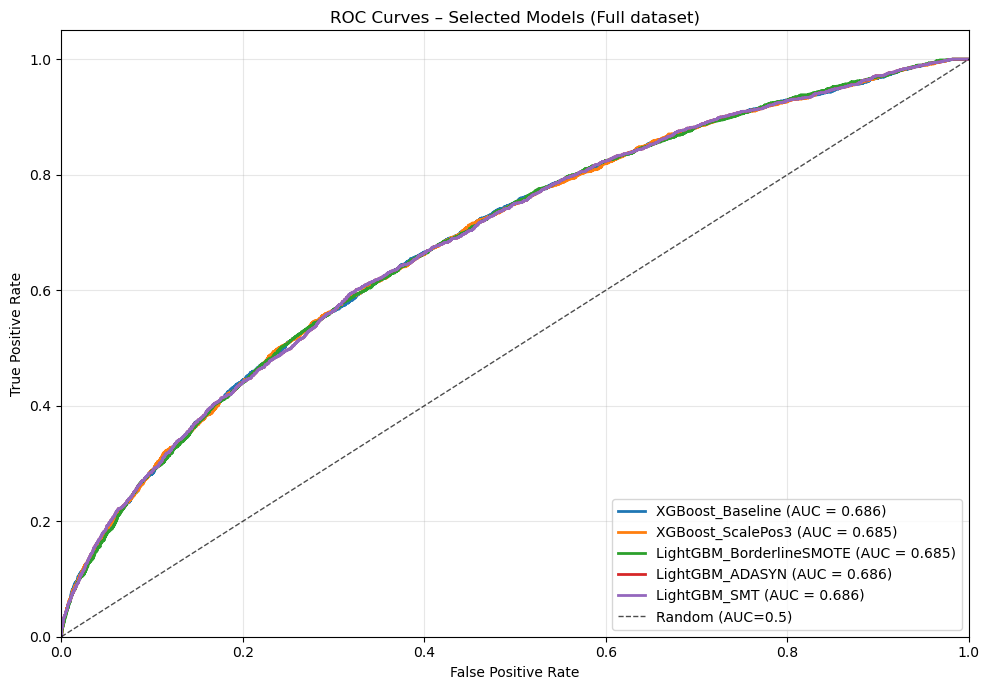

In [50]:

def plot_roc_selected_models(selected):
    dataset = data_preprocessed_by_group['full']
    X_tr, y_tr = dataset["x_train_preprocessed"], dataset["y_train"]
    X_te, y_te = dataset["x_test_preprocessed"], dataset["y_test"]

    plt.figure(figsize=(10, 7))
    for name in selected:
        if name not in models:
            print(f"Skipping {name}: not found in models dict")
            continue

        model = models[name]
        # Build the same kind of pipeline used in your evaluation loop
        if "BorderlineSMOTE" in name:
            pipe = ImbPipeline(steps=[('borderlinesmote', BorderlineSMOTE(random_state=42)), ('clf', model)])
        elif "SMOTEENN" in name:
            pipe = ImbPipeline(steps=[('smoteenn', SMOTEENN(random_state=42)), ('clf', model)])
        else:
            pipe = Pipeline(steps=[('clf', model)])

        try:
            pipe.fit(X_tr, y_tr)
            y_proba = pipe.predict_proba(X_te)[:, 1]
            fpr, tpr, _ = roc_curve(y_te, y_proba)
            auc_score = roc_auc_score(y_te, y_proba)
            plt.plot(fpr, tpr, linewidth=2, label=f"{name} (AUC = {auc_score:.3f})")
        except Exception as e:
            print(f"Error with {name}: {e}")

    plt.plot([0, 1], [0, 1], 'k--', linewidth=1, alpha=0.7, label='Random (AUC=0.5)')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves – Selected Models (Full dataset)')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Run it
plot_roc_selected_models(selected_models)

### Adjustment and Evaluation of Selected Models Accross Thresholds 

In [51]:
def evaluate_selected_models_at_threshold(selected, threshold):
    dataset = data_preprocessed_by_group['full']
    X_tr, y_tr = dataset["x_train_preprocessed"], dataset["y_train"]
    X_te, y_te = dataset["x_test_preprocessed"], dataset["y_test"]


    rows = []
    for name in selected:
        if name not in models:
            print(f"Skipping {name}: not found in models dict")
            continue

        model = models[name]
        # Build the same kind of pipeline used before
        if "BorderlineSMOTE" in name:
            pipe = ImbPipeline(steps=[('borderlinesmote', BorderlineSMOTE(random_state=42)), ('clf', model)])
        elif "SMOTEENN" in name:
            pipe = ImbPipeline(steps=[('smoteenn', SMOTEENN(random_state=42)), ('clf', model)])
        else:
            pipe = Pipeline(steps=[('clf', model)])

        try:
            pipe.fit(X_tr, y_tr)
            y_score = pipe.predict_proba(X_te)[:, 1]
            y_pred_t = (y_score >= threshold).astype(int)

            acc = accuracy_score(y_te, y_pred_t)
            prec, rec, f1, _ = precision_recall_fscore_support(y_te, y_pred_t, average='binary', zero_division=0)
            auc = roc_auc_score(y_te, y_score)  # unaffected by threshold

            rows.append({
                "model": name,
                "threshold": threshold,
                "accuracy": acc,
                "precision": prec,
                "recall": rec,
                "f1": f1,
                "roc_auc": auc
            })


        except Exception as e:
            print(f"Error with {name}: {e}")

    df = pd.DataFrame(rows).sort_values(["f1", "roc_auc"], ascending=False).reset_index(drop=True)
    print(f"Evaluation at threshold = {threshold}")
    display(df)
    return df


for thres in np.arange(0.1,1.0,0.1):
    print(f'The Metrics of Threshold {thres} :')
    evaluate_selected_models_at_threshold(selected_models, threshold=thres)

The Metrics of Threshold 0.1 :


c:\Users\xianj\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [14:58:44] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\xianj\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [14:58:45] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Number of positive: 72326, number of negative: 72326
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017636 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 24508
[LightGBM] [Info] Number of data points in the train set: 144652, number of used features: 110
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 9086, number of negative: 72326
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005733 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1175
[LightGBM] [Info] Number of data points in the train set: 81412, number of used features: 106
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111605 -> initscore=-2.074449
[LightGBM] [Info] Start training from score -2.074449


c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 9086, number of negative: 72326
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004991 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1175
[LightGBM] [Info] Number of data points in the train set: 81412, number of used features: 106
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111605 -> initscore=-2.074449
[LightGBM] [Info] Start training from score -2.074449
Evaluation at threshold = 0.1


c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


model  threshold  accuracy  precision    recall  \
0           LightGBM_ADASYN        0.1  0.596787   0.170588  0.676794   
1              LightGBM_SMT        0.1  0.596787   0.170588  0.676794   
2  LightGBM_BorderlineSMOTE        0.1  0.577577   0.166192  0.693527   
3         XGBoost_ScalePos3        0.1  0.144935   0.114721  0.992074   
4          XGBoost_Baseline        0.1  0.129852   0.113536  0.998679   

         f1   roc_auc  
0  0.272494  0.685821  
1  0.272494  0.685821  
2  0.268131  0.685353  
3  0.205660  0.685480  
4  0.203893  0.685919

The Metrics of Threshold 0.2 :


c:\Users\xianj\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [14:58:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\xianj\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [14:58:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Number of positive: 72326, number of negative: 72326
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015505 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 24508
[LightGBM] [Info] Number of data points in the train set: 144652, number of used features: 110
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 9086, number of negative: 72326
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005468 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1175
[LightGBM] [Info] Number of data points in the train set: 81412, number of used features: 106
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111605 -> initscore=-2.074449
[LightGBM] [Info] Start training from score -2.074449


c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 9086, number of negative: 72326
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005346 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1175
[LightGBM] [Info] Number of data points in the train set: 81412, number of used features: 106
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111605 -> initscore=-2.074449
[LightGBM] [Info] Start training from score -2.074449
Evaluation at threshold = 0.2


c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


model  threshold  accuracy  precision    recall  \
0  LightGBM_BorderlineSMOTE        0.2  0.841260   0.278393  0.265522   
1           LightGBM_ADASYN        0.2  0.845632   0.281485  0.247028   
2              LightGBM_SMT        0.2  0.845632   0.281485  0.247028   
3         XGBoost_ScalePos3        0.2  0.433084   0.144686  0.830911   
4          XGBoost_Baseline        0.2  0.205316   0.119652  0.963012   

         f1   roc_auc  
0  0.271805  0.685353  
1  0.263133  0.685821  
2  0.263133  0.685821  
3  0.246457  0.685480  
4  0.212857  0.685919

The Metrics of Threshold 0.30000000000000004 :


c:\Users\xianj\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [14:58:56] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\xianj\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [14:58:57] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Number of positive: 72326, number of negative: 72326
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015699 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 24508
[LightGBM] [Info] Number of data points in the train set: 144652, number of used features: 110
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 9086, number of negative: 72326
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011518 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1175
[LightGBM] [Info] Number of data points in the train set: 81412, number of used features: 106
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111605 -> initscore=-2.074449
[LightGBM] [Info] Start training from score -2.074449


c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 9086, number of negative: 72326
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005987 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1175
[LightGBM] [Info] Number of data points in the train set: 81412, number of used features: 106
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111605 -> initscore=-2.074449
[LightGBM] [Info] Start training from score -2.074449
Evaluation at threshold = 0.30000000000000004


c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


model  threshold  accuracy  precision    recall  \
0         XGBoost_ScalePos3        0.3  0.713766   0.199594  0.520035   
1          XGBoost_Baseline        0.3  0.451557   0.147479  0.819022   
2           LightGBM_ADASYN        0.3  0.881497   0.386473  0.105680   
3              LightGBM_SMT        0.3  0.881497   0.386473  0.105680   
4  LightGBM_BorderlineSMOTE        0.3  0.880122   0.368585  0.104359   

         f1   roc_auc  
0  0.288471  0.685480  
1  0.249950  0.685919  
2  0.165975  0.685821  
3  0.165975  0.685821  
4  0.162663  0.685353

The Metrics of Threshold 0.4 :


c:\Users\xianj\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [14:59:02] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\xianj\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [14:59:03] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Number of positive: 72326, number of negative: 72326
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015345 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 24508
[LightGBM] [Info] Number of data points in the train set: 144652, number of used features: 110
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 9086, number of negative: 72326
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005043 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1175
[LightGBM] [Info] Number of data points in the train set: 81412, number of used features: 106
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111605 -> initscore=-2.074449
[LightGBM] [Info] Start training from score -2.074449


c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 9086, number of negative: 72326
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005853 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1175
[LightGBM] [Info] Number of data points in the train set: 81412, number of used features: 106
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111605 -> initscore=-2.074449
[LightGBM] [Info] Start training from score -2.074449
Evaluation at threshold = 0.4


c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


model  threshold  accuracy  precision    recall  \
0          XGBoost_Baseline        0.4  0.686106   0.191674  0.563628   
1         XGBoost_ScalePos3        0.4  0.833644   0.268576  0.284897   
2  LightGBM_BorderlineSMOTE        0.4  0.887688   0.468354  0.048877   
3           LightGBM_ADASYN        0.4  0.888376   0.497585  0.045354   
4              LightGBM_SMT        0.4  0.888376   0.497585  0.045354   

         f1   roc_auc  
0  0.286065  0.685919  
1  0.276496  0.685480  
2  0.088517  0.685353  
3  0.083132  0.685821  
4  0.083132  0.685821

The Metrics of Threshold 0.5 :


c:\Users\xianj\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [14:59:08] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\xianj\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [14:59:09] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Number of positive: 72326, number of negative: 72326
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034187 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 24508
[LightGBM] [Info] Number of data points in the train set: 144652, number of used features: 110
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 9086, number of negative: 72326
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005593 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1175
[LightGBM] [Info] Number of data points in the train set: 81412, number of used features: 106
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111605 -> initscore=-2.074449
[LightGBM] [Info] Start training from score -2.074449


c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 9086, number of negative: 72326
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005786 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1175
[LightGBM] [Info] Number of data points in the train set: 81412, number of used features: 106
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111605 -> initscore=-2.074449
[LightGBM] [Info] Start training from score -2.074449
Evaluation at threshold = 0.5


c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


model  threshold  accuracy  precision    recall  \
0          XGBoost_Baseline        0.5  0.813845   0.249670  0.333333   
1         XGBoost_ScalePos3        0.5  0.877714   0.364090  0.128578   
2           LightGBM_ADASYN        0.5  0.889506   0.648649  0.021136   
3              LightGBM_SMT        0.5  0.889506   0.648649  0.021136   
4  LightGBM_BorderlineSMOTE        0.5  0.888916   0.559524  0.020696   

         f1   roc_auc  
0  0.285499  0.685919  
1  0.190042  0.685480  
2  0.040938  0.685821  
3  0.040938  0.685821  
4  0.039915  0.685353

The Metrics of Threshold 0.6 :


c:\Users\xianj\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [14:59:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\xianj\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [14:59:16] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Number of positive: 72326, number of negative: 72326
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016730 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 24508
[LightGBM] [Info] Number of data points in the train set: 144652, number of used features: 110
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 9086, number of negative: 72326
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006576 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1175
[LightGBM] [Info] Number of data points in the train set: 81412, number of used features: 106
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111605 -> initscore=-2.074449
[LightGBM] [Info] Start training from score -2.074449


c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 9086, number of negative: 72326
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005350 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1175
[LightGBM] [Info] Number of data points in the train set: 81412, number of used features: 106
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111605 -> initscore=-2.074449
[LightGBM] [Info] Start training from score -2.074449
Evaluation at threshold = 0.6


c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


model  threshold  accuracy  precision    recall  \
0          XGBoost_Baseline        0.6  0.871622   0.336832  0.155438   
1         XGBoost_ScalePos3        0.6  0.887835   0.480132  0.063849   
2           LightGBM_ADASYN        0.6  0.889457   0.838710  0.011449   
3              LightGBM_SMT        0.6  0.889457   0.838710  0.011449   
4  LightGBM_BorderlineSMOTE        0.6  0.888867   0.655172  0.008366   

         f1   roc_auc  
0  0.212715  0.685919  
1  0.112709  0.685480  
2  0.022589  0.685821  
3  0.022589  0.685821  
4  0.016522  0.685353

The Metrics of Threshold 0.7000000000000001 :


c:\Users\xianj\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [14:59:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\xianj\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [14:59:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Number of positive: 72326, number of negative: 72326
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024967 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 24508
[LightGBM] [Info] Number of data points in the train set: 144652, number of used features: 110
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 9086, number of negative: 72326
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010534 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1175
[LightGBM] [Info] Number of data points in the train set: 81412, number of used features: 106
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111605 -> initscore=-2.074449
[LightGBM] [Info] Start training from score -2.074449


c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 9086, number of negative: 72326
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005510 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1175
[LightGBM] [Info] Number of data points in the train set: 81412, number of used features: 106
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111605 -> initscore=-2.074449
[LightGBM] [Info] Start training from score -2.074449
Evaluation at threshold = 0.7000000000000001


c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


model  threshold  accuracy  precision    recall  \
0          XGBoost_Baseline        0.7  0.887197   0.463977  0.070894   
1         XGBoost_ScalePos3        0.7  0.888867   0.556962  0.019375   
2           LightGBM_ADASYN        0.7  0.888769   0.733333  0.004844   
3              LightGBM_SMT        0.7  0.888769   0.733333  0.004844   
4  LightGBM_BorderlineSMOTE        0.7  0.888523   0.750000  0.001321   

         f1   roc_auc  
0  0.122995  0.685919  
1  0.037447  0.685480  
2  0.009624  0.685821  
3  0.009624  0.685821  
4  0.002637  0.685353

The Metrics of Threshold 0.8 :


c:\Users\xianj\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [14:59:29] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\xianj\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [14:59:30] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Number of positive: 72326, number of negative: 72326
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016993 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 24508
[LightGBM] [Info] Number of data points in the train set: 144652, number of used features: 110
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 9086, number of negative: 72326
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008987 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1175
[LightGBM] [Info] Number of data points in the train set: 81412, number of used features: 106
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111605 -> initscore=-2.074449
[LightGBM] [Info] Start training from score -2.074449


c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 9086, number of negative: 72326
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008594 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1175
[LightGBM] [Info] Number of data points in the train set: 81412, number of used features: 106
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111605 -> initscore=-2.074449
[LightGBM] [Info] Start training from score -2.074449
Evaluation at threshold = 0.8


c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


model  threshold  accuracy  precision    recall  \
0          XGBoost_Baseline        0.8  0.888916   0.589286  0.014531   
1         XGBoost_ScalePos3        0.8  0.888671   0.666667  0.004403   
2  LightGBM_BorderlineSMOTE        0.8  0.888474   1.000000  0.000440   
3           LightGBM_ADASYN        0.8  0.888376   0.000000  0.000000   
4              LightGBM_SMT        0.8  0.888376   0.000000  0.000000   

         f1   roc_auc  
0  0.028363  0.685919  
1  0.008749  0.685480  
2  0.000880  0.685353  
3  0.000000  0.685821  
4  0.000000  0.685821

The Metrics of Threshold 0.9 :


c:\Users\xianj\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [14:59:37] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\xianj\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [14:59:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Number of positive: 72326, number of negative: 72326
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025043 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 24508
[LightGBM] [Info] Number of data points in the train set: 144652, number of used features: 110
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 9086, number of negative: 72326
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006148 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1175
[LightGBM] [Info] Number of data points in the train set: 81412, number of used features: 106
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111605 -> initscore=-2.074449
[LightGBM] [Info] Start training from score -2.074449


c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 9086, number of negative: 72326
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005552 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1175
[LightGBM] [Info] Number of data points in the train set: 81412, number of used features: 106
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111605 -> initscore=-2.074449
[LightGBM] [Info] Start training from score -2.074449
Evaluation at threshold = 0.9


c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


model  threshold  accuracy  precision   recall       f1  \
0          XGBoost_Baseline        0.9  0.888474        1.0  0.00044  0.00088   
1           LightGBM_ADASYN        0.9  0.888425        0.0  0.00000  0.00000   
2              LightGBM_SMT        0.9  0.888425        0.0  0.00000  0.00000   
3         XGBoost_ScalePos3        0.9  0.888425        0.0  0.00000  0.00000   
4  LightGBM_BorderlineSMOTE        0.9  0.888425        0.0  0.00000  0.00000   

    roc_auc  
0  0.685919  
1  0.685821  
2  0.685821  
3  0.685480  
4  0.685353

### Plot Metric Curves Against Thresholds 

Generating threshold analysis curves...


c:\Users\xianj\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [14:59:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\xianj\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [14:59:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Number of positive: 72326, number of negative: 72326
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016821 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 24508
[LightGBM] [Info] Number of data points in the train set: 144652, number of used features: 110
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 70454, number of negative: 72326
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017688 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 24382
[LightGBM] [Info] Number of data points in the train set: 142780, number of used features: 111
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.493444 -> initscore=-0.026224
[LightGBM] [Info] Start training from score -0.026224


c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 72326, number of negative: 72326
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018041 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 24464
[LightGBM] [Info] Number of data points in the train set: 144652, number of used features: 109
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


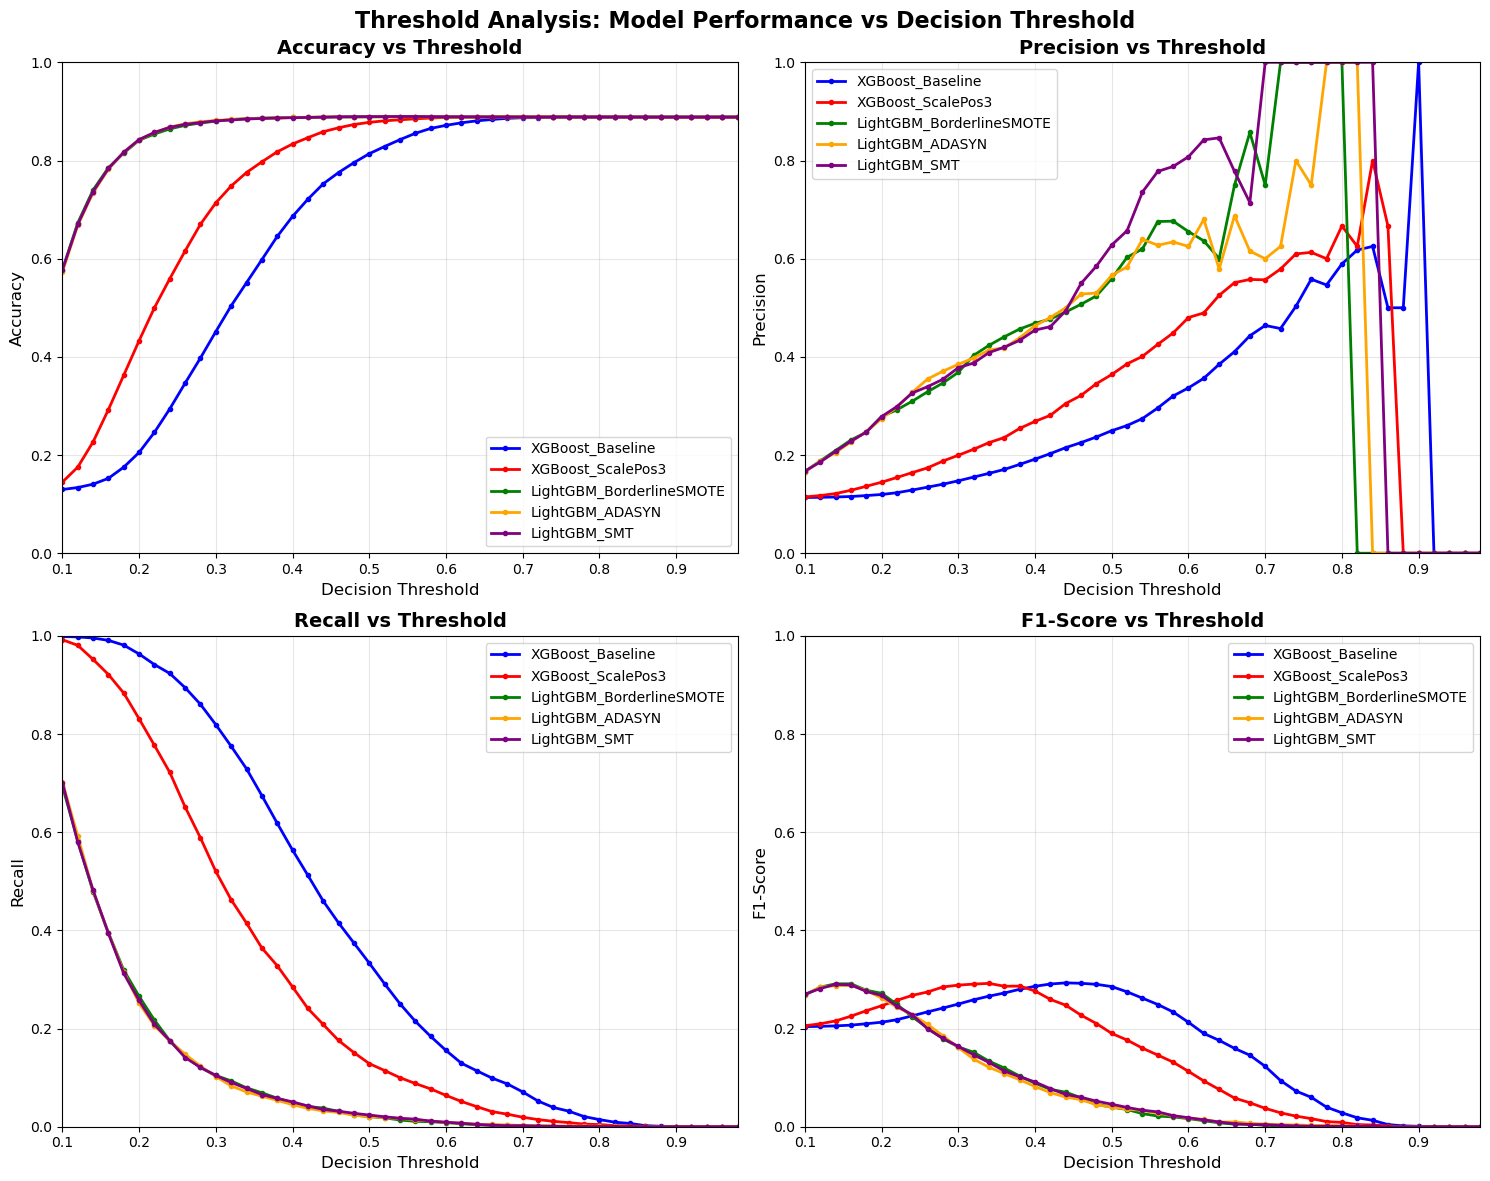


Optimal thresholds based on F1-score:
XGBoost_Baseline: Threshold = 0.440, F1 = 0.2931
XGBoost_ScalePos3: Threshold = 0.340, F1 = 0.2920
LightGBM_BorderlineSMOTE: Threshold = 0.160, F1 = 0.2912
LightGBM_ADASYN: Threshold = 0.160, F1 = 0.2878
LightGBM_SMT: Threshold = 0.140, F1 = 0.2900


In [52]:
def plot_threshold_analysis_curves(selected_models, threshold_range=None):
    """
    Plot comprehensive threshold analysis showing accuracy, precision, recall, F1 vs threshold
    """
    if threshold_range is None:
        threshold_range = np.arange(0.1, 1.0, 0.02)
    
    dataset = data_preprocessed_by_group['full']
    X_tr, y_tr = dataset["x_train_preprocessed"], dataset["y_train"]
    X_te, y_te = dataset["x_test_preprocessed"], dataset["y_test"]
    
    # Store results for all models
    results_by_model = {}
    
    # Get predictions for all models first
    for name in selected_models:
        if name not in models:
            print(f"Skipping {name}: not found in models dict")
            continue
            
        model = models[name]
        
        # Build pipeline
        if "BorderlineSMOTE" in name:
            pipe = ImbPipeline(steps=[('borderlinesmote', BorderlineSMOTE(random_state=42)), ('clf', model)])
        elif "SMOTEENN" in name:
            pipe = ImbPipeline(steps=[('smoteenn', SMOTEENN(random_state=42)), ('clf', model)])
        elif "SMT" in name and "BorderlineSMOTE" not in name and "SMOTEENN" not in name:
            pipe = ImbPipeline(steps=[('smote', SMOTE(random_state=42)), ('clf', model)])
        elif "ADASYN" in name:
            pipe = ImbPipeline(steps=[('adasyn', ADASYN(random_state=42)), ('clf', model)])
        else:
            pipe = Pipeline(steps=[('clf', model)])
        
        try:
            pipe.fit(X_tr, y_tr)
            y_proba = pipe.predict_proba(X_te)[:, 1]
            
            # Calculate metrics for each threshold
            metrics = {
                'thresholds': [],
                'accuracy': [],
                'precision': [],
                'recall': [],
                'f1': []
            }
            
            for threshold in threshold_range:
                y_pred_t = (y_proba >= threshold).astype(int)
                
                acc = accuracy_score(y_te, y_pred_t)
                prec, rec, f1, _ = precision_recall_fscore_support(y_te, y_pred_t, average='binary', zero_division=0)
                
                metrics['thresholds'].append(threshold)
                metrics['accuracy'].append(acc)
                metrics['precision'].append(prec)
                metrics['recall'].append(rec)
                metrics['f1'].append(f1)
            
            results_by_model[name] = metrics
            
        except Exception as e:
            print(f"Error with {name}: {e}")
    
    # Create subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Threshold Analysis: Model Performance vs Decision Threshold', fontsize=16, fontweight='bold')
    
    metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1']
    metric_titles = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    colors = ['blue', 'red', 'green', 'orange', 'purple']
    
    for idx, (metric, title) in enumerate(zip(metrics_to_plot, metric_titles)):
        row = idx // 2
        col = idx % 2
        ax = axes[row, col]
        
        for model_idx, (model_name, model_results) in enumerate(results_by_model.items()):
            color = colors[model_idx % len(colors)]
            ax.plot(model_results['thresholds'], model_results[metric], 
                   label=model_name, linewidth=2, color=color, marker='o', markersize=3)
        
        ax.set_xlabel('Decision Threshold', fontsize=12)
        ax.set_ylabel(title, fontsize=12)
        ax.set_title(f'{title} vs Threshold', fontsize=14, fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=10)
        ax.set_xlim(threshold_range[0], threshold_range[-1])
        ax.set_ylim(0, 1)
    
    plt.tight_layout()
    plt.show()


    
    return results_by_model

# Run the analysis
print("Generating threshold analysis curves...")
threshold_results = plot_threshold_analysis_curves(selected_models)

# Find optimal thresholds for each model based on F1 score
print("\nOptimal thresholds based on F1-score:")
optimal_thresholds = {}
for model_name, results in threshold_results.items():
    max_f1_idx = np.argmax(results['f1'])
    optimal_threshold = results['thresholds'][max_f1_idx]
    max_f1 = results['f1'][max_f1_idx]
    optimal_thresholds[model_name] = optimal_threshold
    print(f"{model_name}: Threshold = {optimal_threshold:.3f}, F1 = {max_f1:.4f}")

### Plot Precision vs Recall Curves  

c:\Users\xianj\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [15:00:08] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\xianj\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [15:00:09] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Number of positive: 72326, number of negative: 72326
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027578 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 24508
[LightGBM] [Info] Number of data points in the train set: 144652, number of used features: 110
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 70454, number of negative: 72326
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019143 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 24382
[LightGBM] [Info] Number of data points in the train set: 142780, number of used features: 111
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.493444 -> initscore=-0.026224
[LightGBM] [Info] Start training from score -0.026224


c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 72326, number of negative: 72326
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018170 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 24464
[LightGBM] [Info] Number of data points in the train set: 144652, number of used features: 109
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


c:\Users\xianj\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


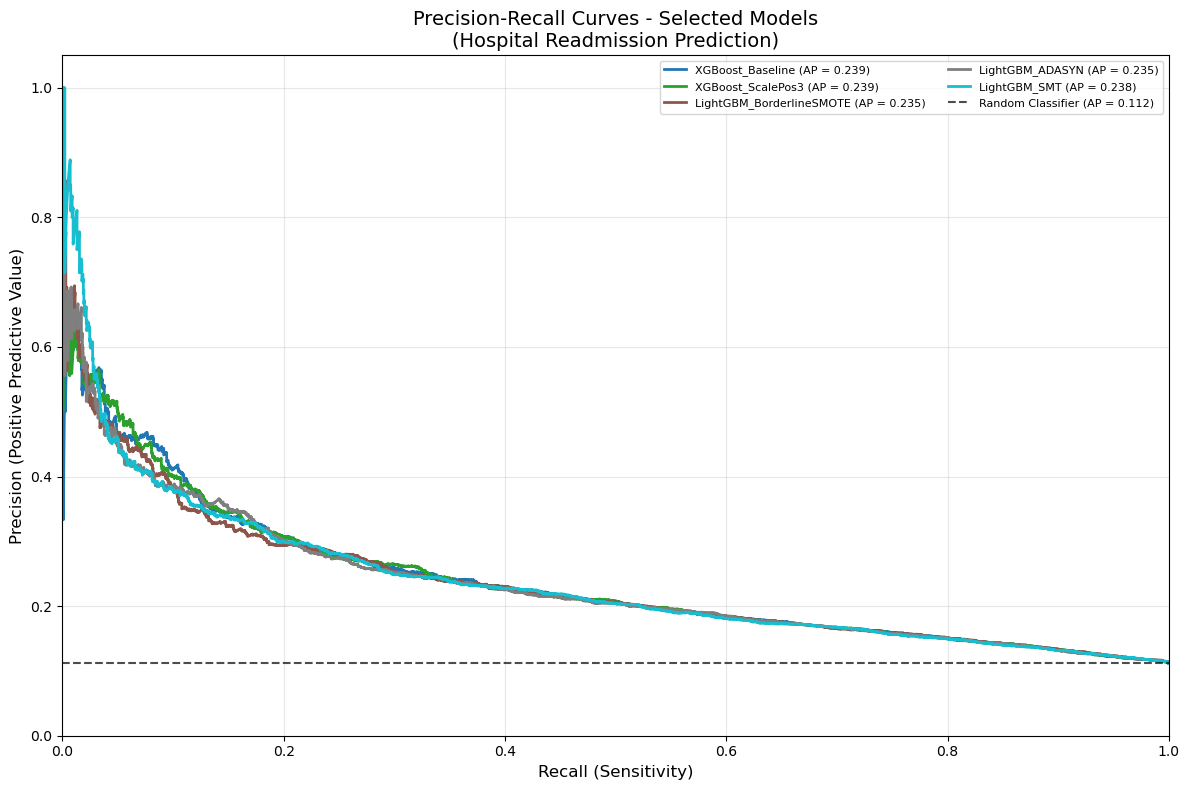

In [53]:
def plot_precision_recall_curves(selected_model_names, data_group='full'):
    """
    Plot Precision-Recall curves for selected models only
    """
    dataset = data_preprocessed_by_group[data_group]
    X_tr, y_tr = dataset["x_train_preprocessed"], dataset["y_train"]
    X_te, y_te = dataset["x_test_preprocessed"], dataset["y_test"]
    
    plt.figure(figsize=(12, 8))
    colors = plt.cm.tab10(np.linspace(0, 1, len(selected_model_names)))
    
    for idx, name in enumerate(selected_model_names):
        if name not in models:
            print(f"Skipping {name}: not found in models dict")
            continue
            
        model = models[name]
        
        # Build pipeline based on model type
        if "SMT" in name and "BorderlineSMOTE" not in name and "SMOTEENN" not in name:
            pipe = ImbPipeline(steps=[('smote', SMOTE(random_state=42)), ('clf', model)])
        elif "ADASYN" in name:
            pipe = ImbPipeline(steps=[('adasyn', ADASYN(random_state=42)), ('clf', model)])
        elif "BorderlineSMOTE" in name:
            pipe = ImbPipeline(steps=[('borderlinesmote', BorderlineSMOTE(random_state=42)), ('clf', model)])
        elif "SMOTEENN" in name:
            pipe = ImbPipeline(steps=[('smoteenn', SMOTEENN(random_state=42)), ('clf', model)])
        elif "MultinomialNB" in name:
            pipe = Pipeline(steps=[("ensure_non_negative", EnsureNonNegative()), ("clf", model)])
        else:
            pipe = Pipeline(steps=[('clf', model)])
        
        try:
            # Fit and predict
            pipe.fit(X_tr, y_tr)
            y_proba = pipe.predict_proba(X_te)[:, 1]
            
            # Calculate PR curve
            precision, recall, _ = precision_recall_curve(y_te, y_proba)
            ap_score = average_precision_score(y_te, y_proba)
            
            # Plot
            plt.plot(recall, precision, linewidth=2, 
                    label=f'{name} (AP = {ap_score:.3f})', 
                    color=colors[idx])
            
        except Exception as e:
            print(f"Error with {name}: {e}")
    
    # Add baseline (random classifier)
    baseline = np.sum(y_te) / len(y_te)  # Proportion of positive class
    plt.axhline(y=baseline, color='k', linestyle='--', alpha=0.7,
                label=f'Random Classifier (AP = {baseline:.3f})')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall (Sensitivity)', fontsize=12)
    plt.ylabel('Precision (Positive Predictive Value)', fontsize=12)
    plt.title('Precision-Recall Curves - Selected Models\n(Hospital Readmission Prediction)', fontsize=14)
    plt.legend(loc="upper right", fontsize=8, ncol=2)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Run the PR curve plot for selected models only
plot_precision_recall_curves(selected_models)

# **Hyperparameter Tuning**

### Tune XGBoost with GridSearchCV

In [ ]:
param_grid = {
    'max_depth': [3, 4, 5, 6, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [190, 195, 200, 205, 210],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],  
}


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# ✅ XGBoost with fixed parameters
grid = GridSearchCV(
    estimator=XGBClassifier(
        use_label_encoder=False, 
        eval_metric='logloss',  # Fixed here
        random_state=42         # Fixed here
    ),
    param_grid=param_grid,
    scoring='roc_auc',
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    n_jobs=-1,  # Use all available cores
    refit=True
)

X_train = data_preprocessed_by_group["full"]["x_train_preprocessed"]
y_train = data_preprocessed_by_group["full"]["y_train"]
X_test  = data_preprocessed_by_group["full"]["x_test_preprocessed"]
y_test  = data_preprocessed_by_group["full"]["y_test"]

grid.fit(X_train, y_train)

print("Best parameters:", grid.best_params_)
print(f"Best CV ROC AUC: {grid.best_score_:.4f}")

# Evaluate best model on the hold-out test set
best_model = grid.best_estimator_
y_proba = best_model.predict_proba(X_test)[:, 1]

threshold = 0.5
y_pred = (y_proba >= threshold).astype(int)

test_auc = roc_auc_score(y_test, y_proba)
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec = recall_score(y_test, y_pred)

print(f"Test ROC AUC: {test_auc:.4f}")
print(f"Test Accuracy: {acc:.4f}")
print(f"Test Precision: {prec:.4f}")
print(f"Test Recall: {rec:.4f}")


c:\Users\xianj\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [20:03:35] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 210, 'subsample': 0.8}
Best CV ROC AUC: 0.6753
Test ROC AUC: 0.6877
Test Accuracy: 0.8885
Test Precision: 0.5200
Test Recall: 0.0114


### Compare Optimised XGBoost with Base XGBoost

c:\Users\xianj\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [20:17:37] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\xianj\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [20:17:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


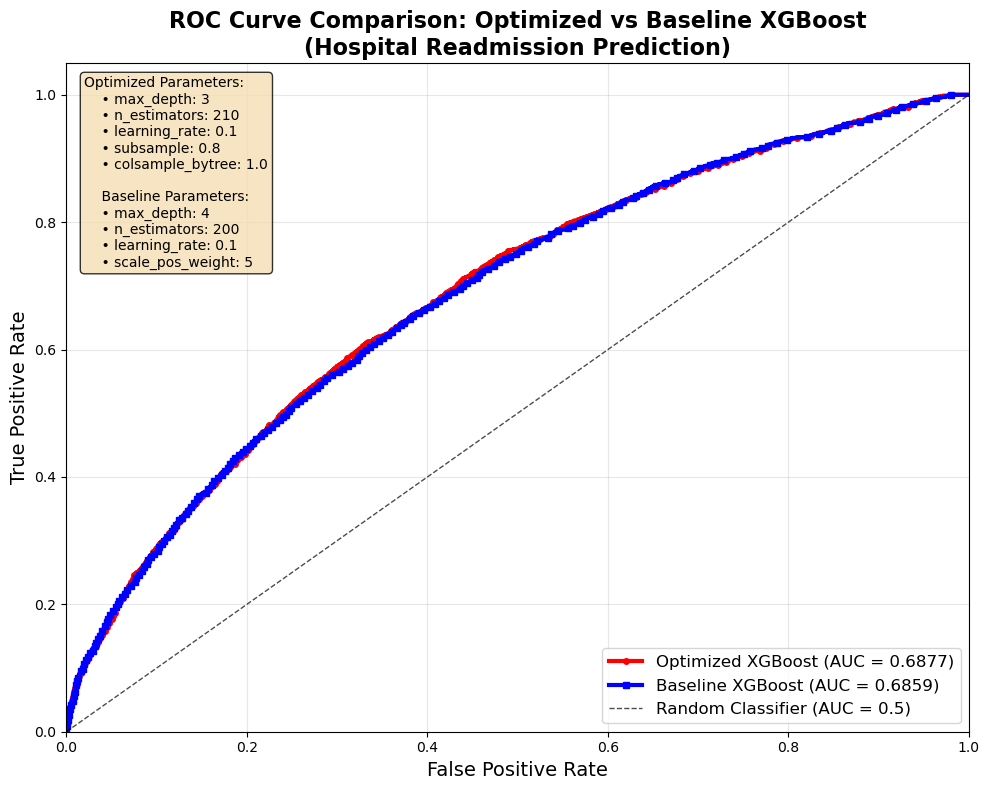

XGBoost Model Comparison Results
Optimized XGBoost ROC AUC: 0.6877
Baseline XGBoost ROC AUC:  0.6859
Improvement: +0.0017

Metrics at threshold = 0.5:
----------------------------------------
Metric          | Optimized | Baseline  | Diff
----------------------------------------
Accuracy     |   0.8885  |   0.8138  | +0.0747
Precision    |   0.5200  |   0.2497  | +0.2703
Recall       |   0.0114  |   0.3333  | -0.3219
F1-Score     |   0.0224  |   0.2855  | -0.2631


In [ ]:
def plot_xgboost_comparison():
    """
    Compare ROC curves between optimized XGBoost and baseline XGBoost
    """
    # Get the preprocessed data
    X_train = data_preprocessed_by_group["full"]["x_train_preprocessed"]
    y_train = data_preprocessed_by_group["full"]["y_train"]
    X_test = data_preprocessed_by_group["full"]["x_test_preprocessed"]
    y_test = data_preprocessed_by_group["full"]["y_test"]
    
    # Define the models
    # Optimized XGBoost with best parameters from GridSearchCV
    xgb_optimized = XGBClassifier(
        colsample_bytree=1.0,
        learning_rate=0.1,
        max_depth=3,
        n_estimators=210,
        subsample=0.8,
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
    )
    
    # Baseline XGBoost
    xgb_baseline = XGBClassifier(
        n_estimators=200,
        max_depth=4,
        learning_rate=0.1,
        scale_pos_weight=5,  # XGBoost equivalent of class_weight='balanced'
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
    )
    
    # Create the plot
    plt.figure(figsize=(10, 8))
    
    # Train and evaluate optimized XGBoost
    xgb_optimized.fit(X_train, y_train)
    y_proba_optimized = xgb_optimized.predict_proba(X_test)[:, 1]
    fpr_optimized, tpr_optimized, _ = roc_curve(y_test, y_proba_optimized)
    auc_optimized = roc_auc_score(y_test, y_proba_optimized)
    
    # Train and evaluate baseline XGBoost
    xgb_baseline.fit(X_train, y_train)
    y_proba_baseline = xgb_baseline.predict_proba(X_test)[:, 1]
    fpr_baseline, tpr_baseline, _ = roc_curve(y_test, y_proba_baseline)
    auc_baseline = roc_auc_score(y_test, y_proba_baseline)
    
    # Plot ROC curves
    plt.plot(fpr_optimized, tpr_optimized, linewidth=3, 
             label=f'Optimized XGBoost (AUC = {auc_optimized:.4f})', 
             color='red', marker='o', markersize=4, markevery=20)
    
    plt.plot(fpr_baseline, tpr_baseline, linewidth=3, 
             label=f'Baseline XGBoost (AUC = {auc_baseline:.4f})', 
             color='blue', marker='s', markersize=4, markevery=20)
    
    # Add diagonal line for random classifier
    plt.plot([0, 1], [0, 1], 'k--', linewidth=1, alpha=0.7, 
             label='Random Classifier (AUC = 0.5)')
    
    # Customize the plot
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.title('ROC Curve Comparison: Optimized vs Baseline XGBoost\n(Hospital Readmission Prediction)', 
              fontsize=16, fontweight='bold')
    plt.legend(loc="lower right", fontsize=12)
    plt.grid(True, alpha=0.3)
    
    # Add text box with model parameters
    textstr = f'''Optimized Parameters:
    • max_depth: 3
    • n_estimators: 210
    • learning_rate: 0.1
    • subsample: 0.8
    • colsample_bytree: 1.0
    
    Baseline Parameters:
    • max_depth: 4
    • n_estimators: 200
    • learning_rate: 0.1
    • scale_pos_weight: 5'''
    
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
    plt.text(0.02, 0.98, textstr, transform=plt.gca().transAxes, fontsize=10,
             verticalalignment='top', bbox=props)
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed comparison
    print("="*60)
    print("XGBoost Model Comparison Results")
    print("="*60)
    print(f"Optimized XGBoost ROC AUC: {auc_optimized:.4f}")
    print(f"Baseline XGBoost ROC AUC:  {auc_baseline:.4f}")
    print(f"Improvement: {auc_optimized - auc_baseline:+.4f}")
    
    # Additional metrics at default threshold (0.5)
    y_pred_optimized = (y_proba_optimized >= 0.5).astype(int)
    y_pred_baseline = (y_proba_baseline >= 0.5).astype(int)
    
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
    
    print("\nMetrics at threshold = 0.5:")
    print("-" * 40)
    print("Metric          | Optimized | Baseline  | Diff")
    print("-" * 40)
    
    # Calculate metrics with correct parameters
    opt_accuracy = accuracy_score(y_test, y_pred_optimized)
    base_accuracy = accuracy_score(y_test, y_pred_baseline)
    
    opt_precision = precision_score(y_test, y_pred_optimized, zero_division=0)
    base_precision = precision_score(y_test, y_pred_baseline, zero_division=0)
    
    opt_recall = recall_score(y_test, y_pred_optimized, zero_division=0)
    base_recall = recall_score(y_test, y_pred_baseline, zero_division=0)
    
    opt_f1 = f1_score(y_test, y_pred_optimized, zero_division=0)
    base_f1 = f1_score(y_test, y_pred_baseline, zero_division=0)
    
    # Print results
    print(f"{'Accuracy':<12} | {opt_accuracy:>8.4f}  | {base_accuracy:>8.4f}  | {opt_accuracy - base_accuracy:+.4f}")
    print(f"{'Precision':<12} | {opt_precision:>8.4f}  | {base_precision:>8.4f}  | {opt_precision - base_precision:+.4f}")
    print(f"{'Recall':<12} | {opt_recall:>8.4f}  | {base_recall:>8.4f}  | {opt_recall - base_recall:+.4f}")
    print(f"{'F1-Score':<12} | {opt_f1:>8.4f}  | {base_f1:>8.4f}  | {opt_f1 - base_f1:+.4f}")
    
    return {
        'optimized_auc': auc_optimized,
        'baseline_auc': auc_baseline,
        'optimized_model': xgb_optimized,
        'baseline_model': xgb_baseline
    }

# Run the comparison
results = plot_xgboost_comparison()